In [1]:
import argparse
import numpy as np
import os
import tabulate
import torch
import torch.nn.functional as F
import torch.nn

import data
import models
import curves
import utils

import pickle
from pylab import rcParams

In [2]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

from scipy.stats import norm

import utils
import time
from torch import nn
import seaborn as sns
from sklearn.manifold import TSNE

In [3]:
def test(model):
    train_res = utils.test(loaders['train'], model, criterion, regularizer)
    test_res = utils.test(loaders['test'], model, criterion, regularizer) 
    print(train_res)
    print(test_res)

In [4]:
def distance(model1, model2):
    par1 = np.concatenate([p.data.cpu().numpy().ravel() for p in model1.parameters()])
    par2 = np.concatenate([p.data.cpu().numpy().ravel() for p in model2.parameters()])
    u = par2 - par1
    dx = np.linalg.norm(u)
    return dx

In [5]:
def get_vector(model1):
    par1 = np.concatenate([p.data.cpu().numpy().ravel() for p in model1.parameters()])
    return par1

In [6]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10
rcParams['figure.dpi'] = 100

In [7]:
def get_model(W, B, architecture):
    model_sampled = architecture.base(num_classes=10, **architecture.kwargs)
    model_samples = np.array(W) #.cpu().data.numpy()
    SIZE = model_sampled.middle_dim

    offset = 0
    for parameter in list(model_sampled.parameters())[:-1]:
        size = int(np.prod(parameter.size())/SIZE)
        value = model_samples[:, offset:offset+size]
        if size==10 or size==1:
             value = value.T
#         print(value.shape)
        value = value.reshape(parameter.size())
#         print(value.shape)
        parameter.data.copy_(torch.from_numpy(value))
        offset += size

    list(model_sampled.parameters())[-1].data.copy_(B.mean(0)) #torch.from_numpy(
    
    return model_sampled

def test(model):
    criterion = F.cross_entropy
    regularizer = None 
    train_res = utils.test(loaders['train'], model, criterion, regularizer)
    test_res = utils.test(loaders['test'], model, criterion, regularizer) 
    print(train_res)
    print(test_res)

# def samples(model):
#     p1 = list(model.parameters())[0].data.cpu().numpy()
#     p2 = list(model.parameters())[1].data.cpu().numpy()
#     p3 = list(model.parameters())[2].transpose(0,1).data.cpu().numpy()
#     samples = np.hstack([p1, p2[:, None], p3])
    
#     return samples

In [8]:
def plot_singl_values(model1, model2, ind, plot=False):
    W1 = list(model1.parameters())[ind].data.numpy()
    W2 = list(model2.parameters())[ind].data.numpy()

    _, s1, _ = np.linalg.svd(W1)
    _, s2, _ = np.linalg.svd(W2)

    if plot:
        fig, axes = plt.subplots(1, 2,)
        axes[0, 0].set_title('W1 model1')
        axes[0, 0].plot(s1)
        axes[0, 1].set_title('W2 model1')
        axes[0, 1].plot(s2)
        plt.show()
    
    return s1, s2

In [9]:
def look_at_models(model1, model2, model3, model4, architecture, index):
    
    if index == 0:
        print("distance between train models", distance(model1, model2))
        print("distance between initial models", distance(model3, model4))
        print("how far model1 go", distance(model1, model3))
        print("how far model2 go", distance(model2, model4))
    
    rcParams['figure.figsize'] = 12, 10
    rcParams['figure.dpi'] = 100
    
    print('initial singular values')
    si1, si2 = plot_singl_values(model3, model4, index, plot=False)
    
    print('train singular values')
    s1, s2 = plot_singl_values(model1, model2, index, plot=False)
    
    print('initial singular values distribution')
    plt.hist(si1, bins = 50, density=True, alpha = 0.5);
    plt.hist(si2, bins = 50, density=True, alpha = 0.5);
    plt.show()
    
    print('train singular values distribution')
    plt.hist(s1, bins = 50, density=True, alpha = 0.5)
    plt.hist(s2, bins = 50, density=True, alpha = 0.5)
    plt.show()
    
    print('train and initial singular values distribution')
    plt.hist(si1, bins = 50, density=True, alpha = 0.5)
    plt.hist(s1, bins = 50, density=True, alpha = 0.5)
    plt.show()
    
    
    if index == 0:
        print('train models eigenvector heatmap')
        heat_image(model1)
        heat_image(model2)


        print('scalar product between train models')
        w1 = get_vector(model1)
        w2 = get_vector(model2)
        print('norms w1, w2', np.linalg.norm(w1), np.linalg.norm(w2))
        print('cos', (w1*w2).sum()/(np.linalg.norm(w1)*np.linalg.norm(w2)))
    
    
    

In [10]:
def get_ev(model, index=0):
    W11 = list(model.parameters())[index].data.numpy()
    A = W11.T @ W11
    l, v = np.linalg.eig(A)
    v = np.real(v)
    l = np.real(l)
    return v, l
    

def heat_image(model):
    
    ev, e = get_ev(model)
    N = 5
    fig, ax = plt.subplots(1, N)
    
#     W11 = list(model.parameters())[0].data.numpy()
#     _, _, vh = np.linalg.svd(W11)
#     ev = vh.T @ ev
#     ev = ev>ev.mean()
    
    
    rcParams['figure.figsize'] = 15, 15
    rcParams['figure.dpi'] = 100
    
    for ind, (im, l) in enumerate(zip(ev.T[:N], e[:N])):
        im = np.abs(im.reshape((28, 28)))

        ax[ind].imshow(im)
        ax[ind].set_title(l)
        
#     plt.colorbar()
#     plt.axis('off')
    plt.show()

In [11]:
architecture = getattr(models, "LinearMNIST") #LinearOneLayer LogRegression
model = architecture.base(num_classes=10, **architecture.kwargs)

loaders, num_classes = data.loaders(
    "MNIST",
    "data",
    128,
    1,
    "VGG",
    True)

criterion = F.cross_entropy
regularizer = None 



model1 = architecture.base(num_classes=10, **architecture.kwargs)
model2 = architecture.base(num_classes=10, **architecture.kwargs)
model3 = architecture.base(num_classes=10, **architecture.kwargs)
model4 = architecture.base(num_classes=10, **architecture.kwargs)

You are going to run models on the test set. Are you sure?


In [12]:
model1.load_state_dict(torch.load('curves_mnist/Linear//curve1/checkpoint-20.pt')['model_state'])
model2.load_state_dict(torch.load('curves_mnist/Linear/curve2/checkpoint-20.pt')['model_state'])

model3.load_state_dict(torch.load('curves_mnist/Linear/curve1/checkpoint-0.pt')['model_state'])
model4.load_state_dict(torch.load('curves_mnist/Linear/curve2/checkpoint-0.pt')['model_state'])


In [13]:
test(model1)
test(model2)

{'nll': 0.0067212377587643765, 'loss': 0.0067212377587643765, 'accuracy': 99.865}
{'nll': 0.0784570493221283, 'loss': 0.0784570493221283, 'accuracy': 98.13}
{'nll': 0.006876623245018224, 'loss': 0.006876623245018224, 'accuracy': 99.865}
{'nll': 0.08016016612052917, 'loss': 0.08016016612052917, 'accuracy': 98.01}


In [15]:
W1 = list(model1.parameters())[0].cpu().data.numpy()
W1.shape
_, s1, vh = np.linalg.svd(W1)
vh.shape
A = W1.T @ W1
l, v = np.linalg.eig(A)
v = np.real(v)

In [43]:
F.softmax(model1(torch.tensor(vh[:1])))

/home/anokhin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor([[0.1054, 0.1067, 0.0767, 0.0320, 0.0240, 0.3925, 0.1653, 0.0818, 0.0070,
         0.0086]], grad_fn=<SoftmaxBackward>)

/home/anokhin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


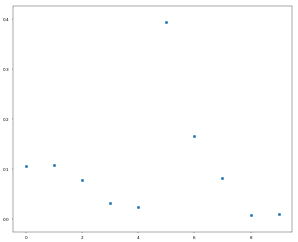

/home/anokhin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


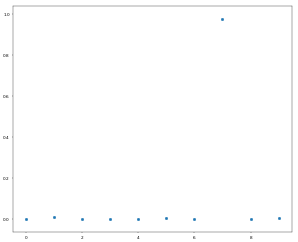

/home/anokhin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


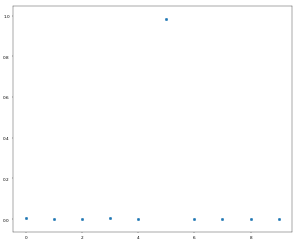

/home/anokhin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


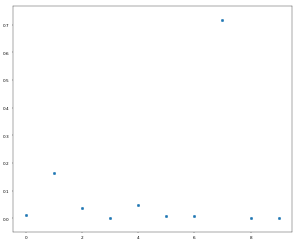

/home/anokhin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


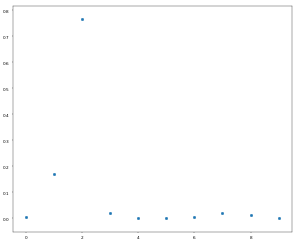

/home/anokhin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


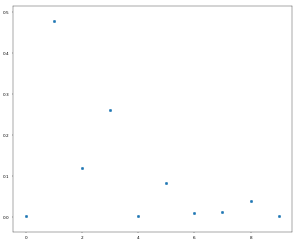

/home/anokhin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


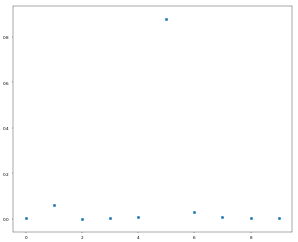

/home/anokhin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


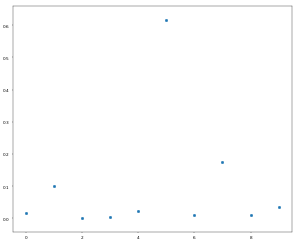

/home/anokhin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


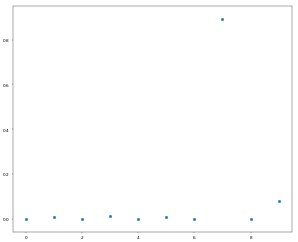

/home/anokhin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


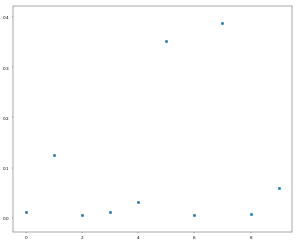

In [47]:
rcParams['figure.dpi'] = 30
for i in range(10):   
    plt.scatter(np.arange(10), F.softmax(model1(torch.tensor(vh[i:i+1]))).cpu().data)
    plt.show()

In [52]:
 F.softmax(model1(torch.tensor(vh[-2:-1])))

/home/anokhin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor([[0.0253, 0.1428, 0.0184, 0.0493, 0.0087, 0.5285, 0.0147, 0.1732, 0.0121,
         0.0269]], grad_fn=<SoftmaxBackward>)

/home/anokhin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


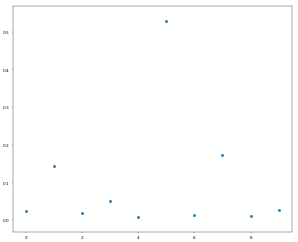

/home/anokhin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


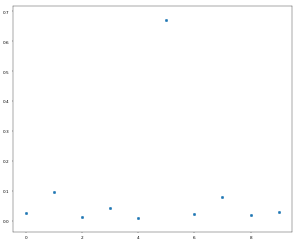

/home/anokhin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


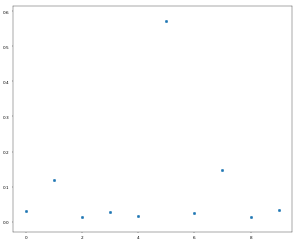

/home/anokhin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


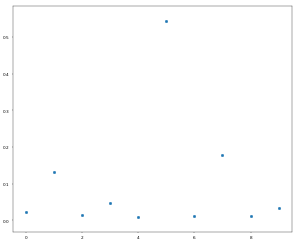

/home/anokhin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


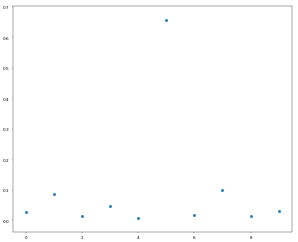

/home/anokhin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


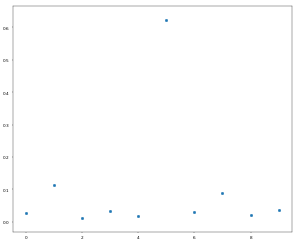

/home/anokhin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


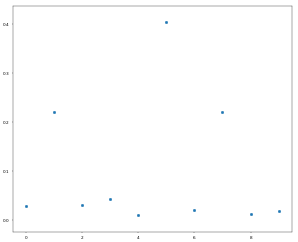

/home/anokhin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


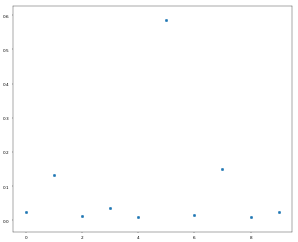

/home/anokhin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


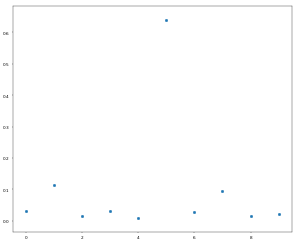

/home/anokhin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


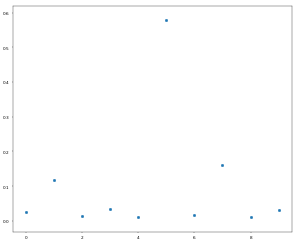

In [53]:
rcParams['figure.dpi'] = 30
for i in range(10):   
    plt.scatter(np.arange(10), F.softmax(model1(torch.tensor(vh[-i-2:-i-1]))).cpu().data)
    plt.show()

In [54]:
# F.softmax(model1(torch.tensor(vh[-10:])))

distance between train models 97.46482
distance between initial models 101.527214
how far model1 go 11.323303
how far model2 go 11.326316
initial singular values
train singular values
initial singular values distribution


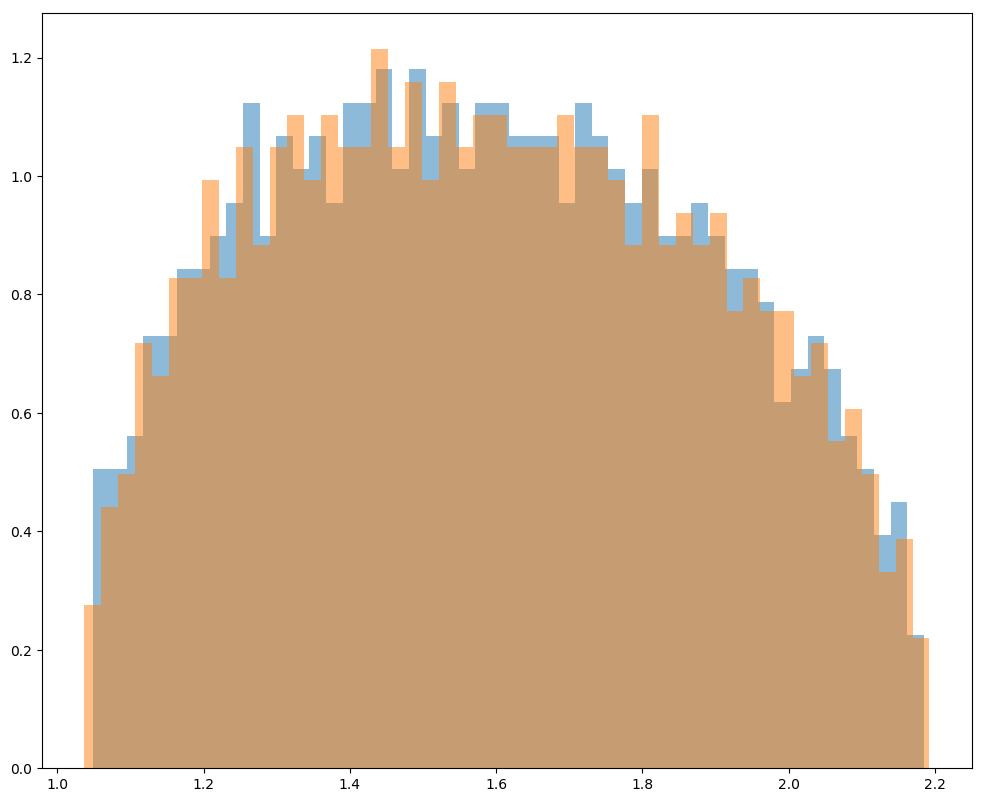

train singular values distribution


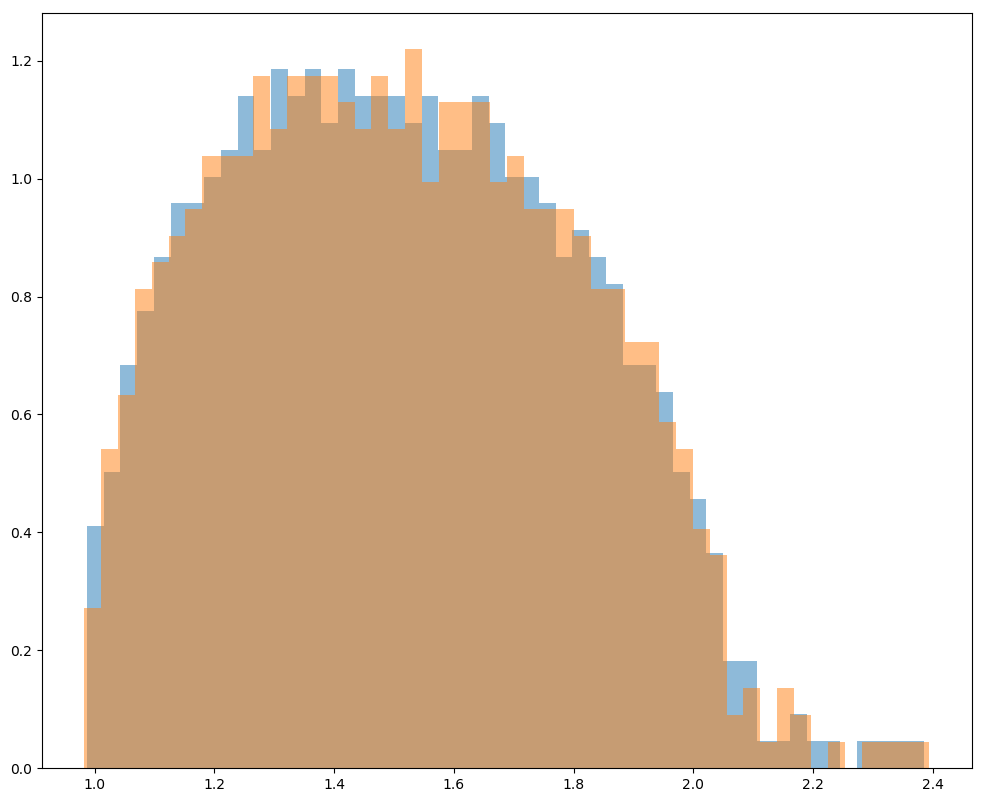

train and initial singular values distribution


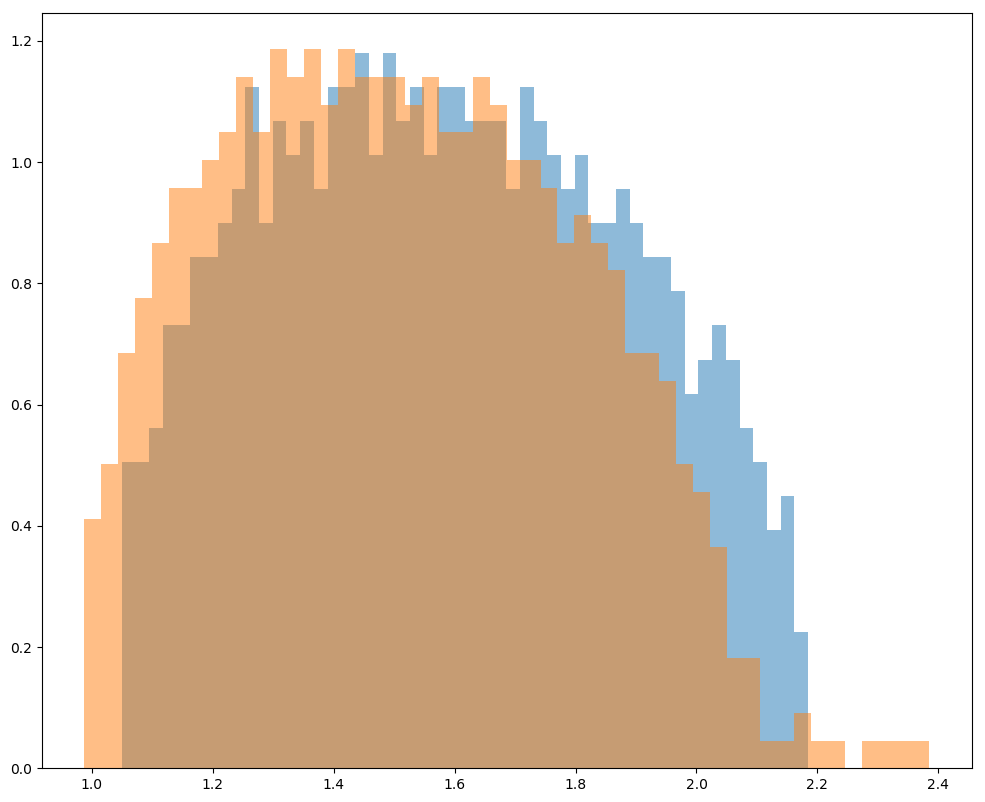

train models eigenvector heatmap


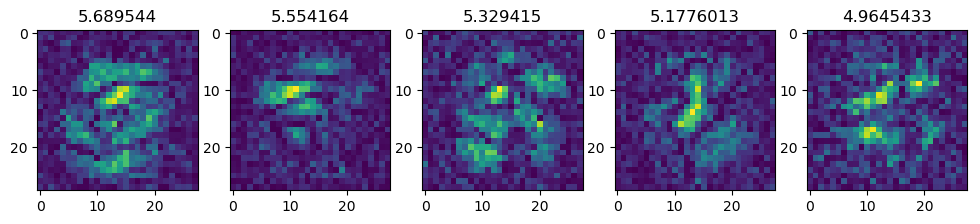

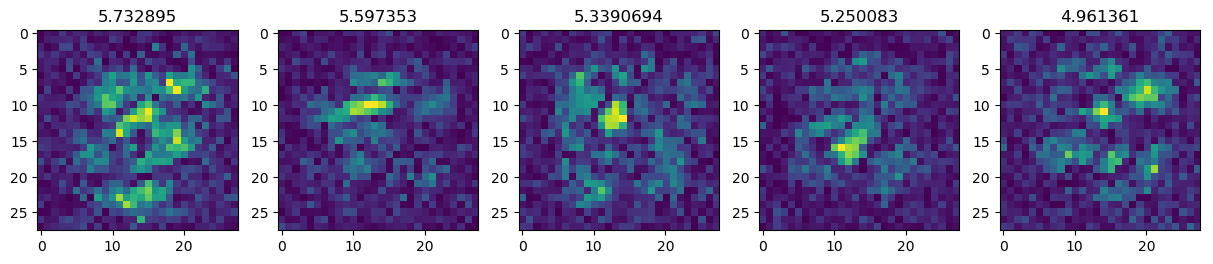

scalar product between train models
norms w1, w2 68.93379 68.9541
cos 0.0007466679


In [12]:
look_at_models(model1, model2, model3, model4, architecture, 0)

distance between train models 97.46482
distance between initial models 101.527214
how far model1 go 11.323303
how far model2 go 11.326316
initial singular values
train singular values
initial singular values distribution


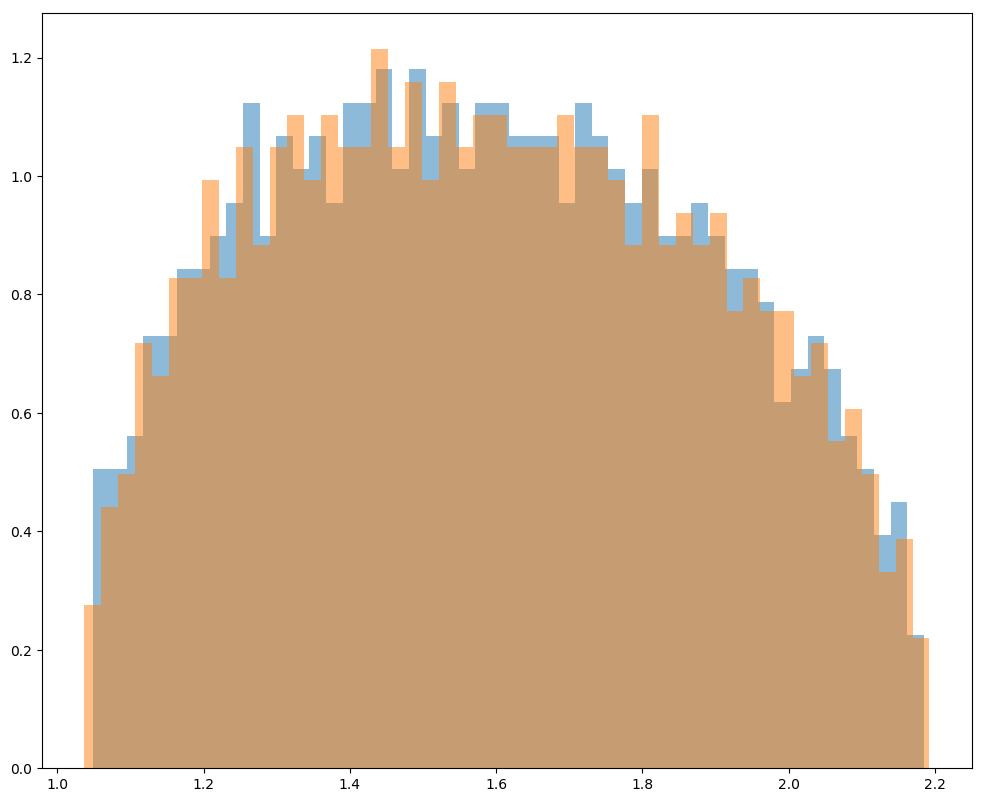

train singular values distribution


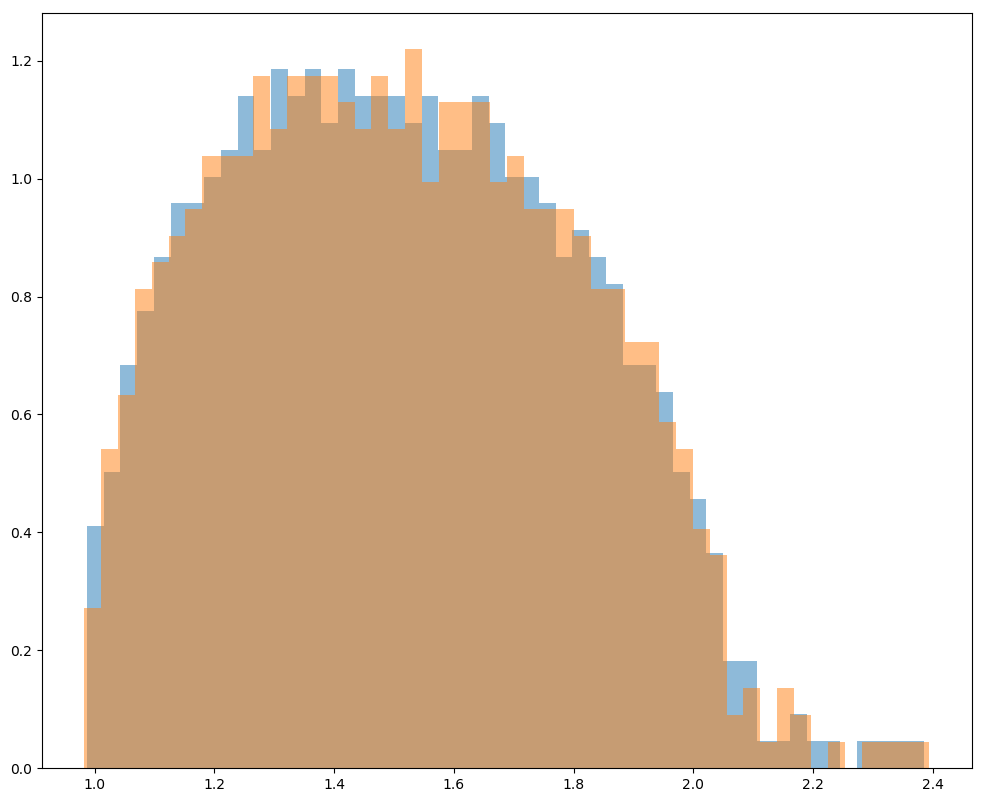

train and initial singular values distribution


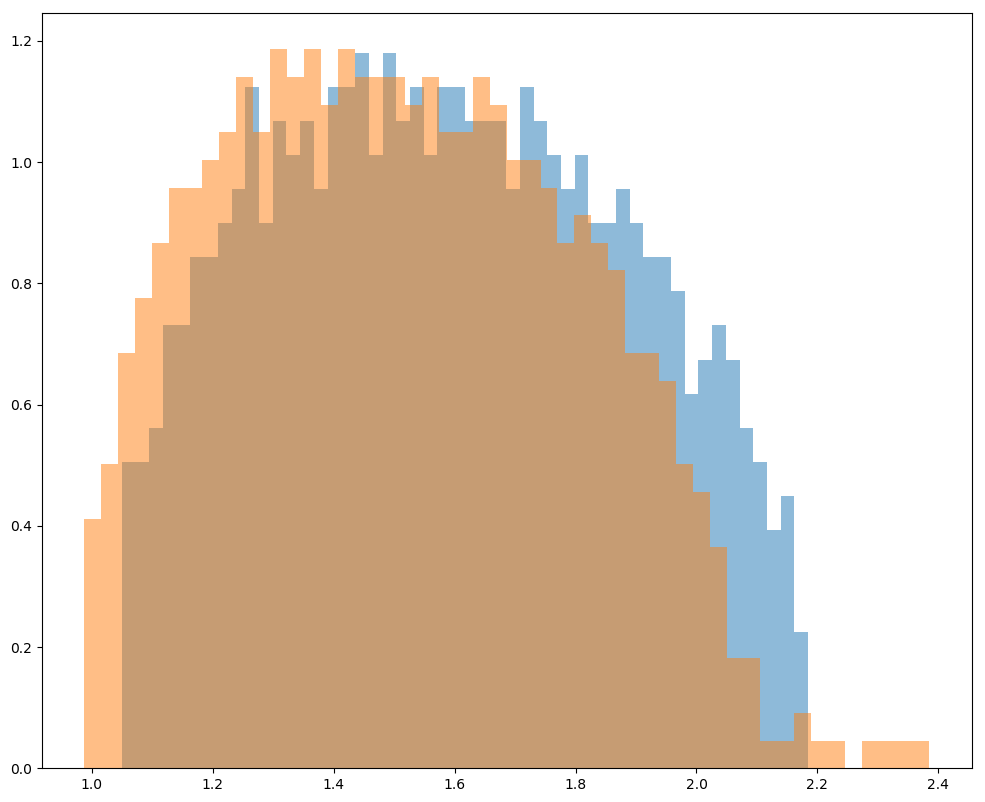

train models eigenvector heatmap


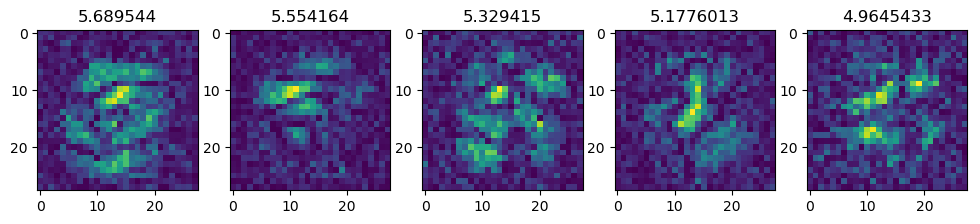

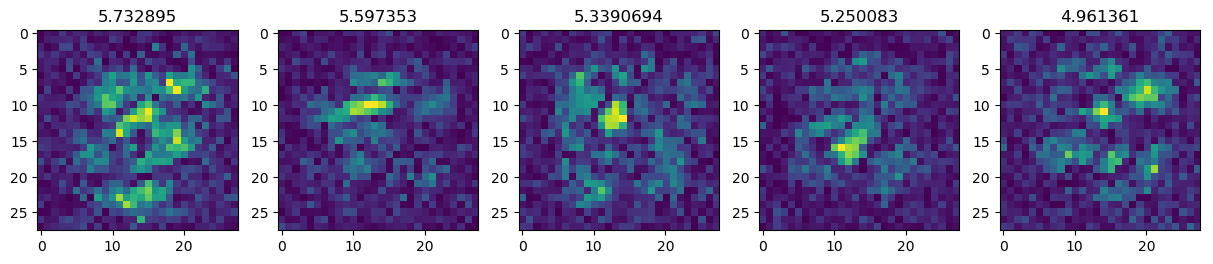

scalar product between train models
norms w1, w2 68.93379 68.9541
cos 0.0007466679


In [13]:
look_at_models(model1, model2, model3, model4, architecture, 0)

index =  2 torch.Size([6144, 6144])
initial singular values
train singular values
initial singular values distribution


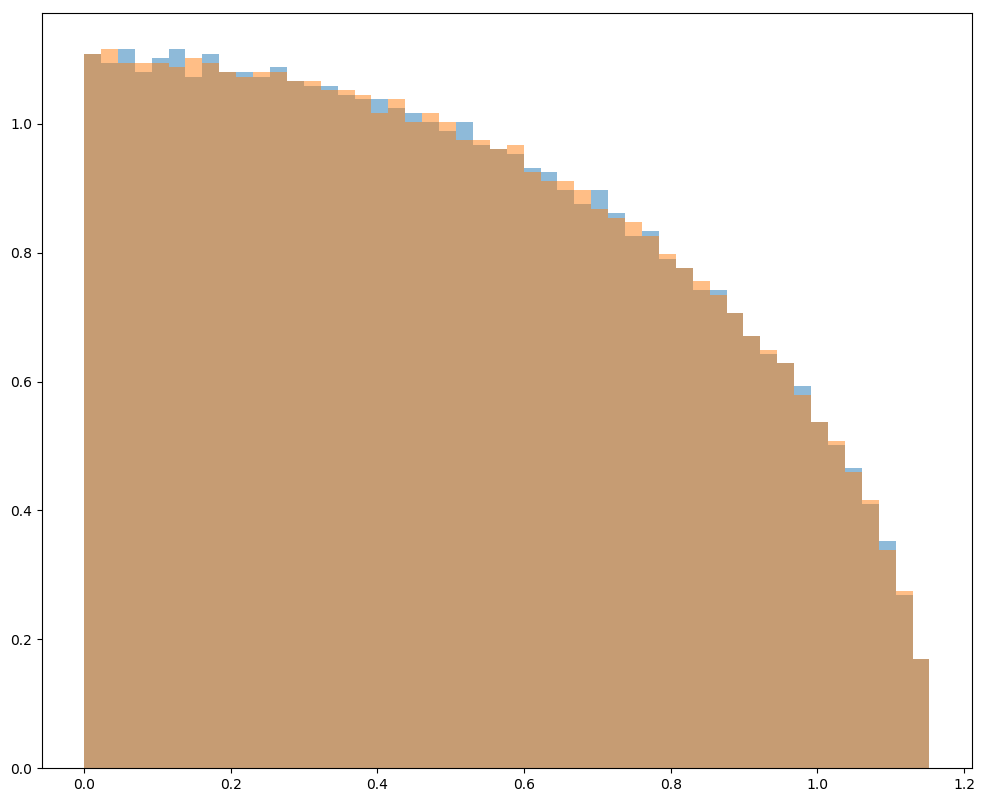

train singular values distribution


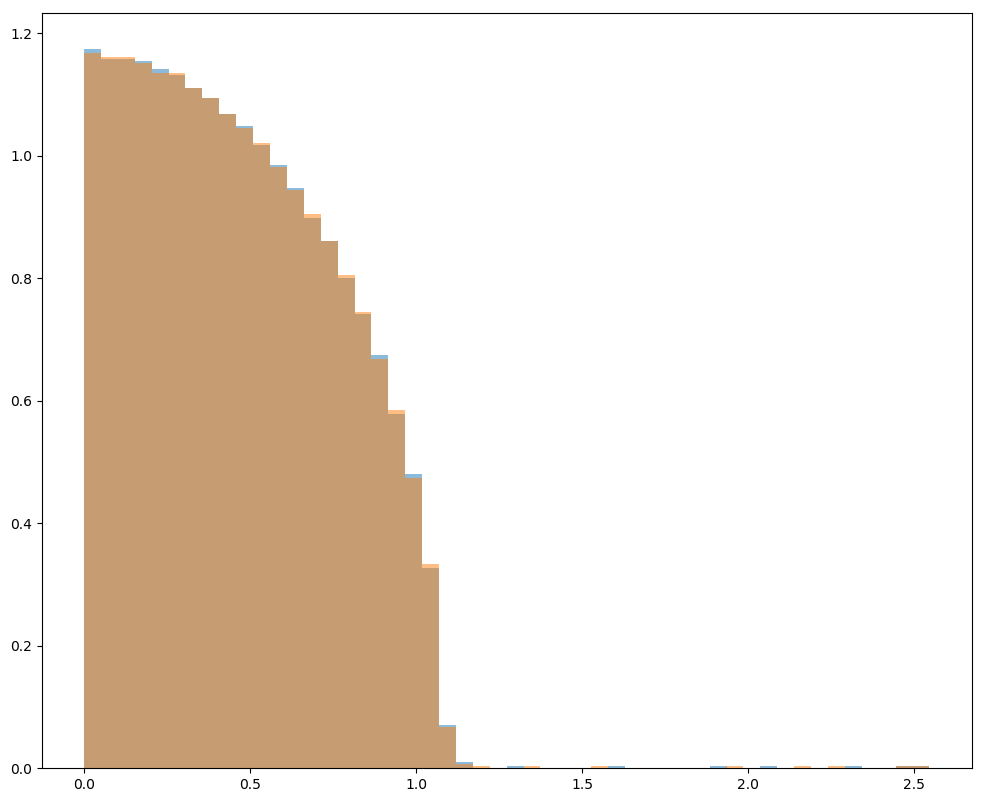

train and initial singular values distribution


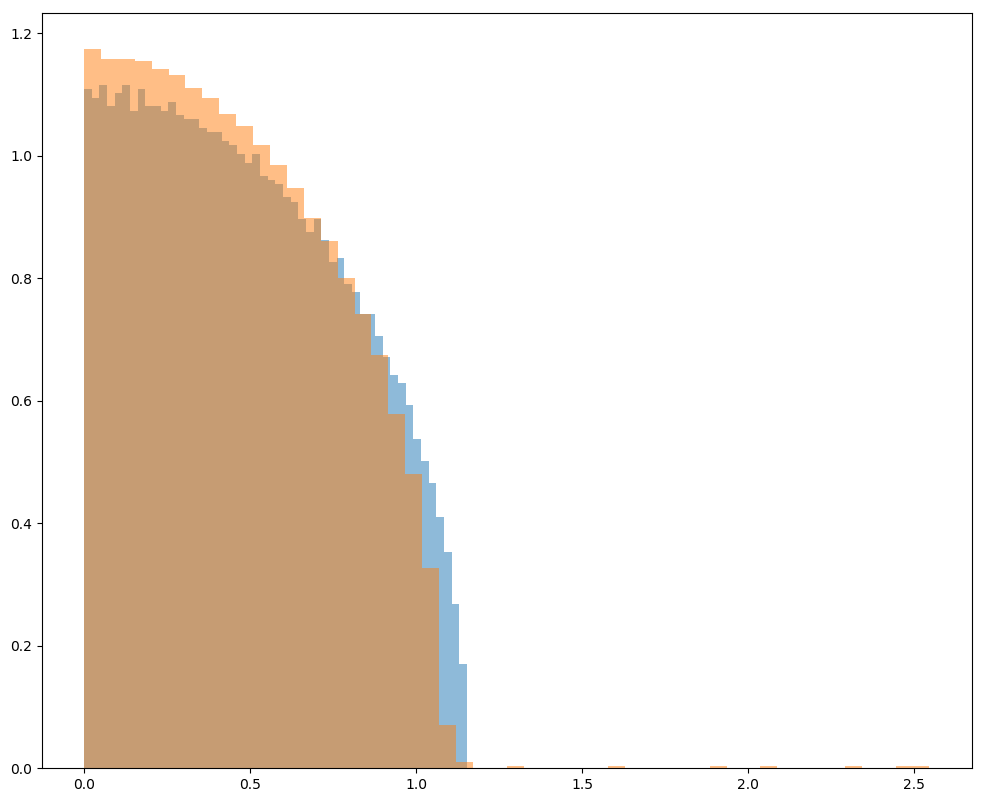

index =  4 torch.Size([1152, 6144])
initial singular values
train singular values
initial singular values distribution


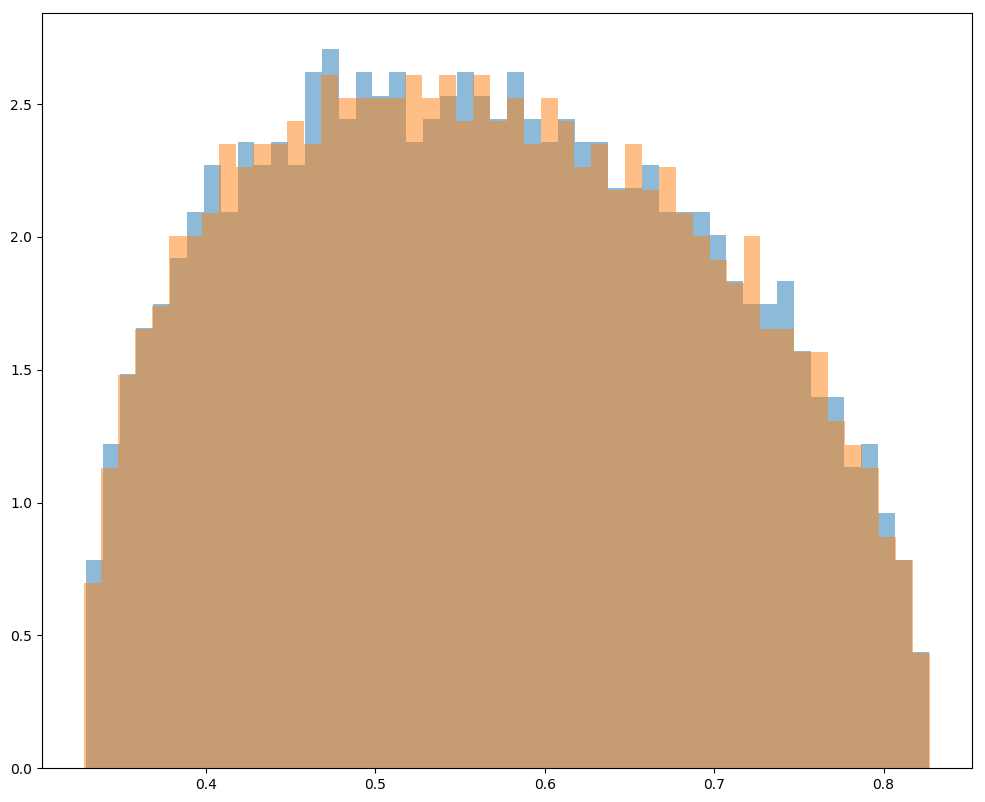

train singular values distribution


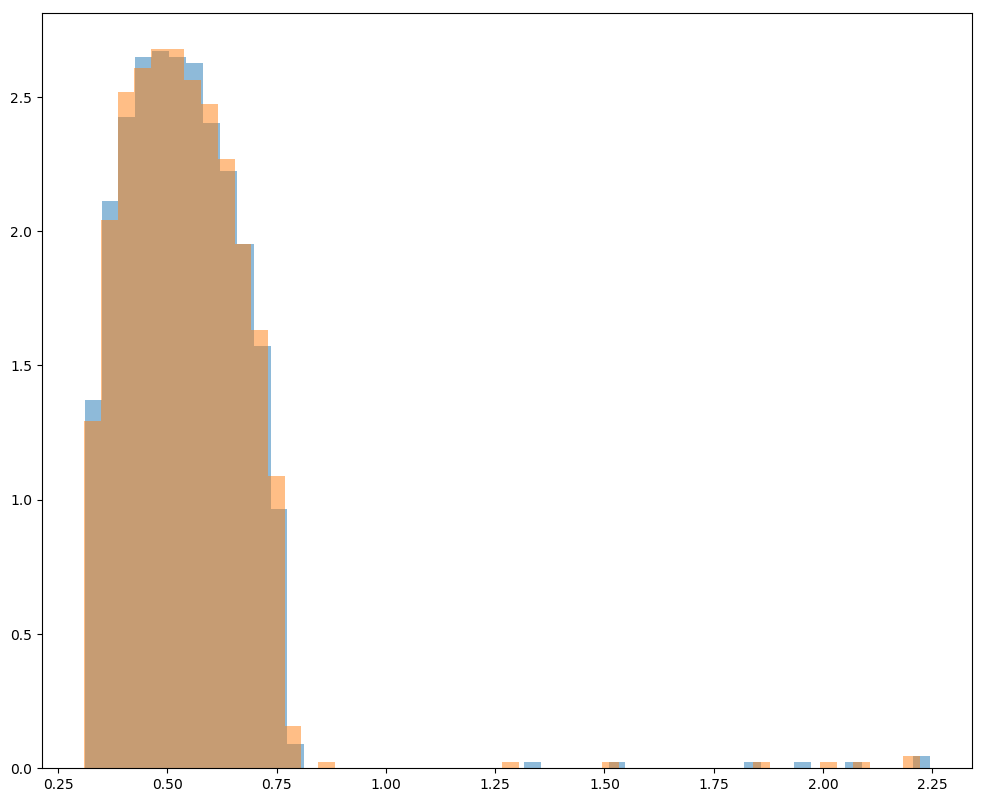

train and initial singular values distribution


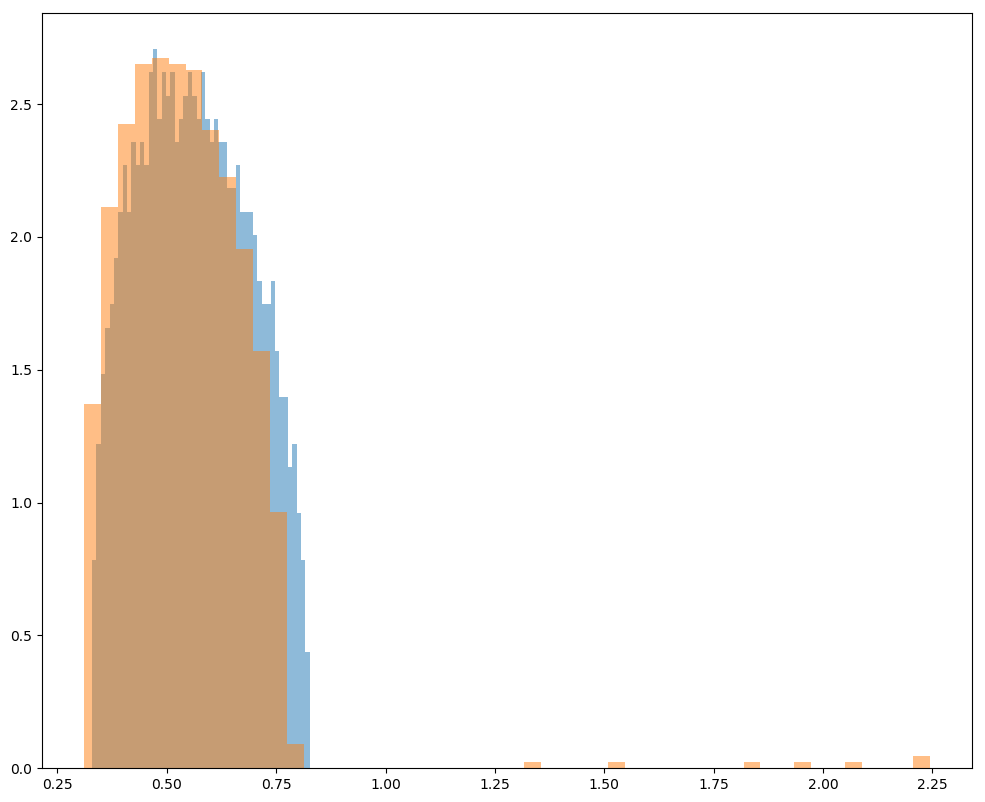

index =  6 torch.Size([1000, 1152])
initial singular values
train singular values
initial singular values distribution


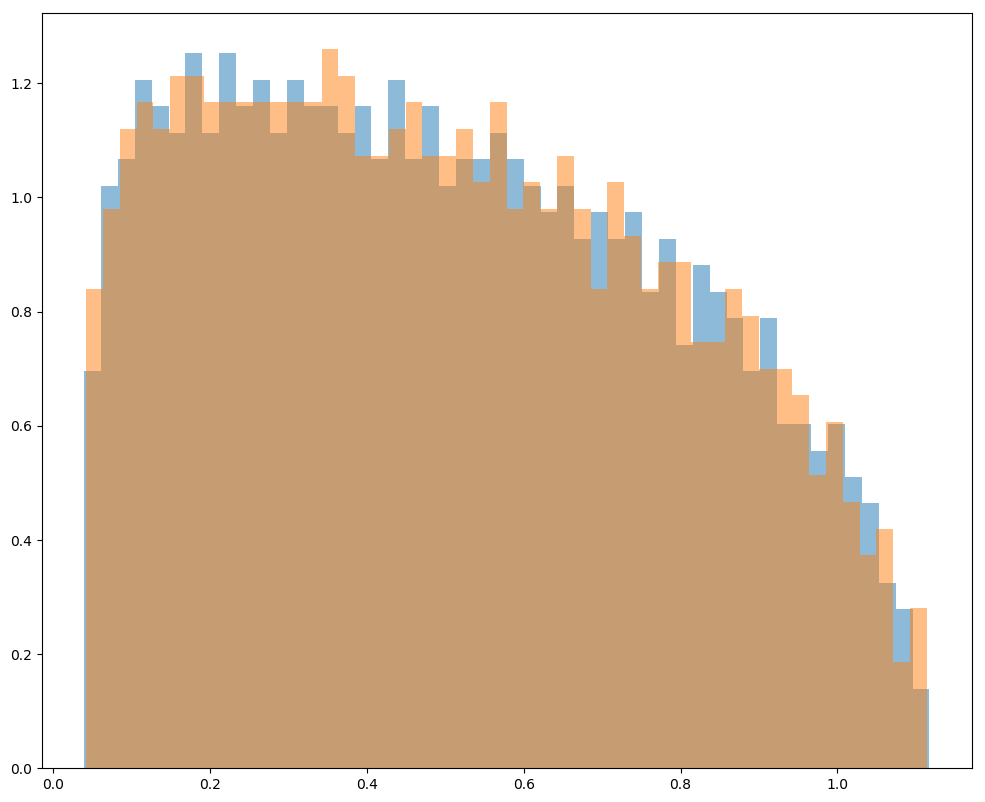

train singular values distribution


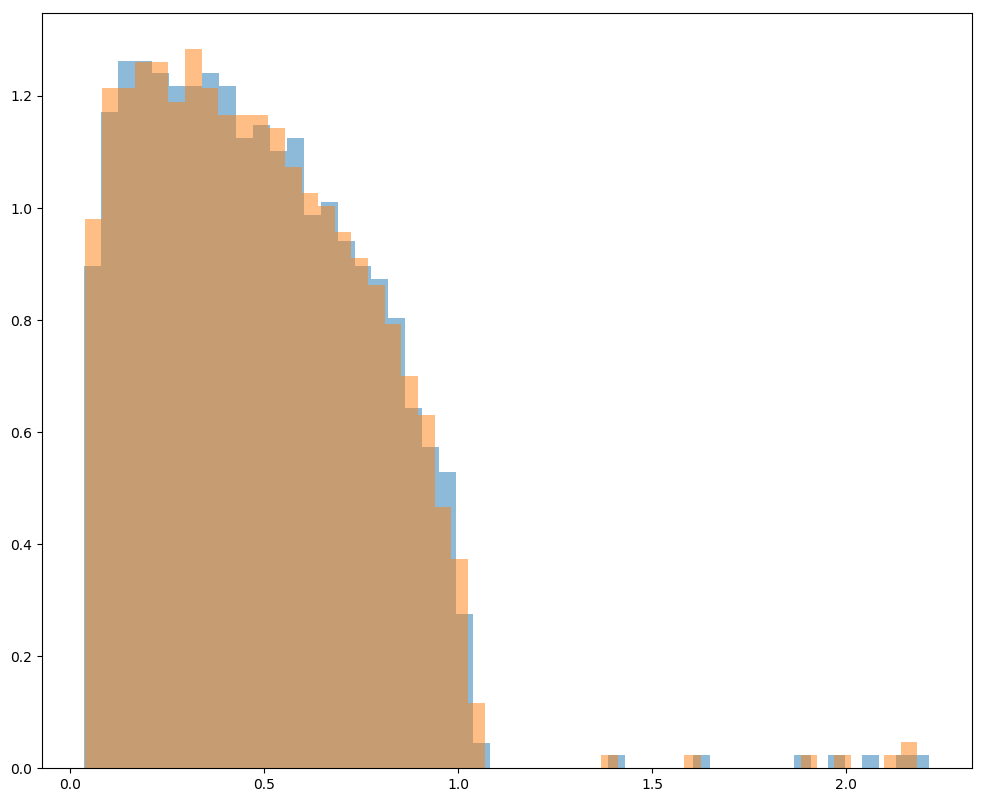

train and initial singular values distribution


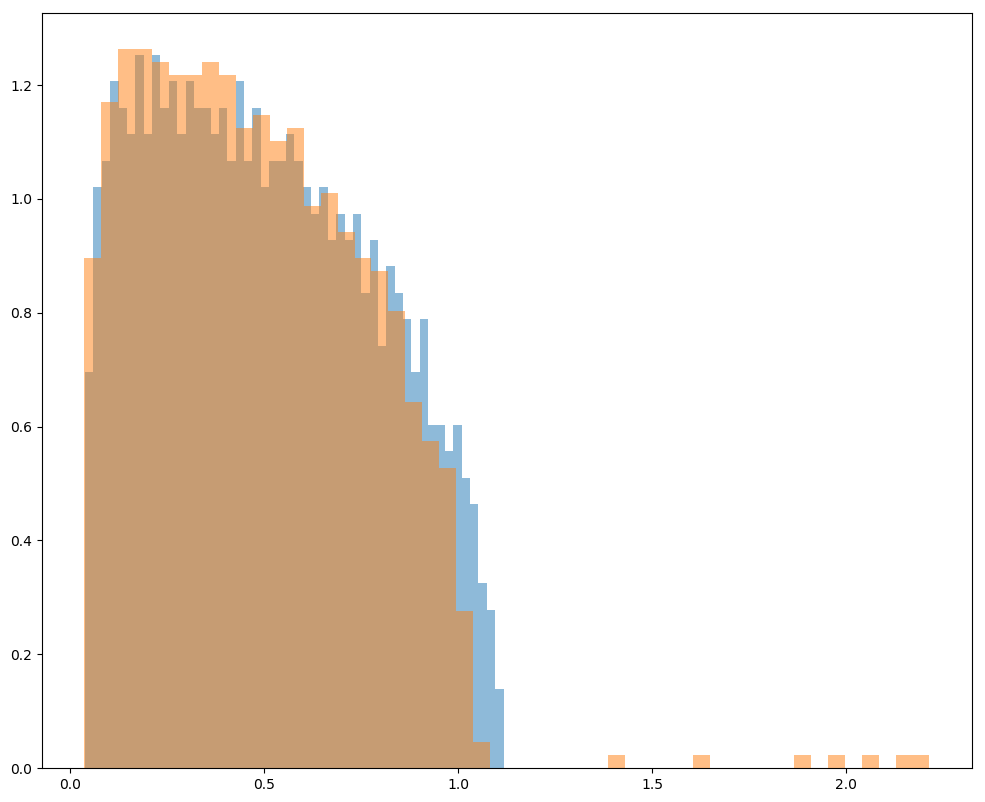

index =  8 torch.Size([1000, 1000])
initial singular values
train singular values
initial singular values distribution


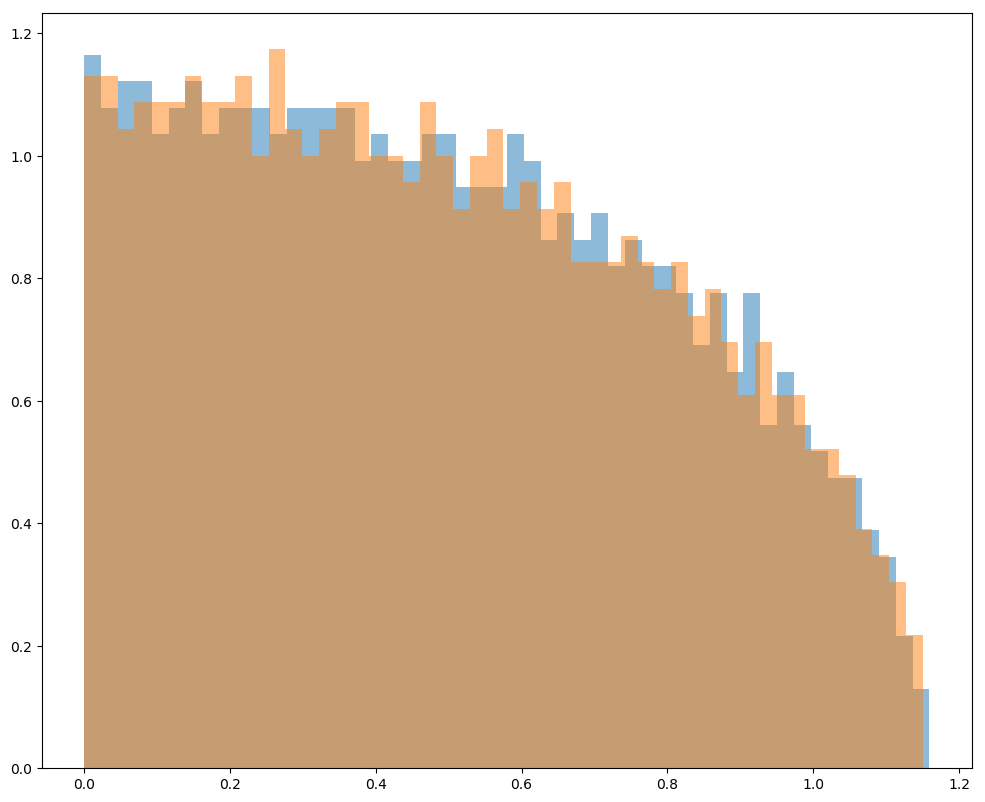

train singular values distribution


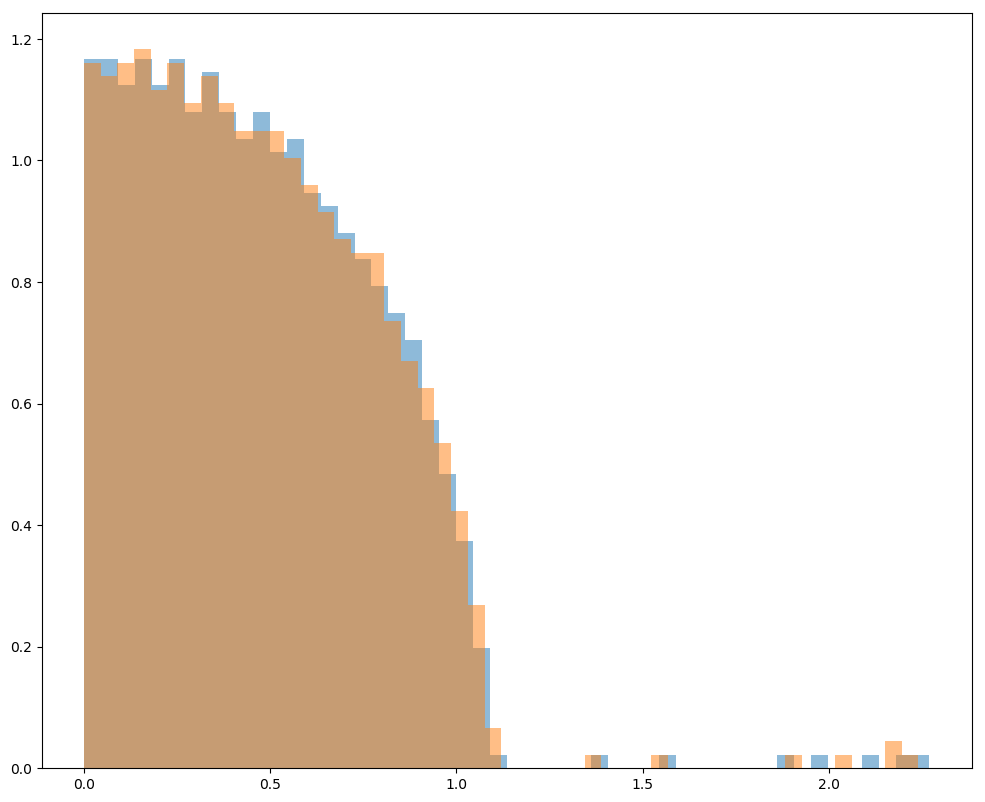

train and initial singular values distribution


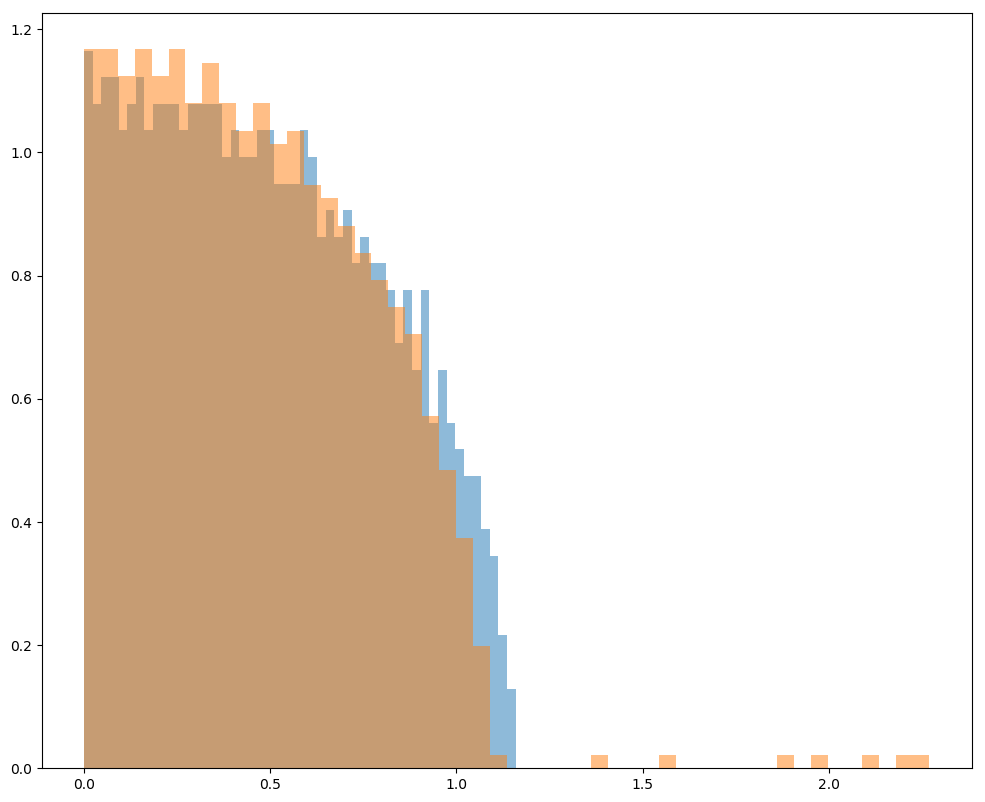

index =  10 torch.Size([10, 1000])
initial singular values
train singular values
initial singular values distribution


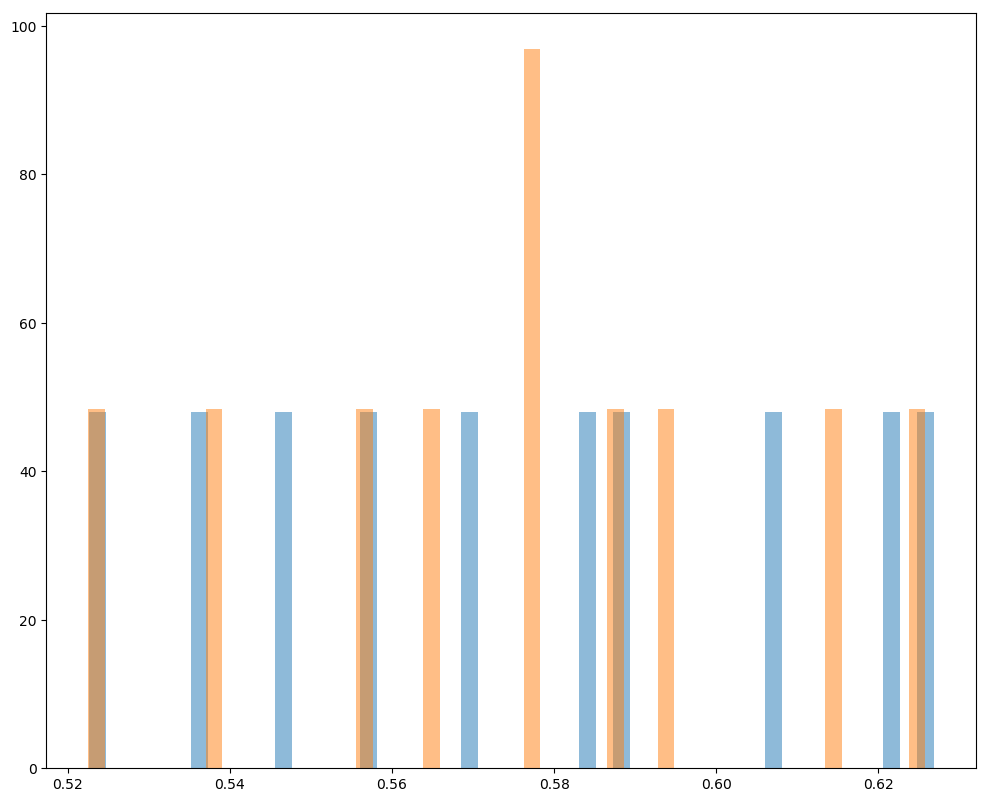

train singular values distribution


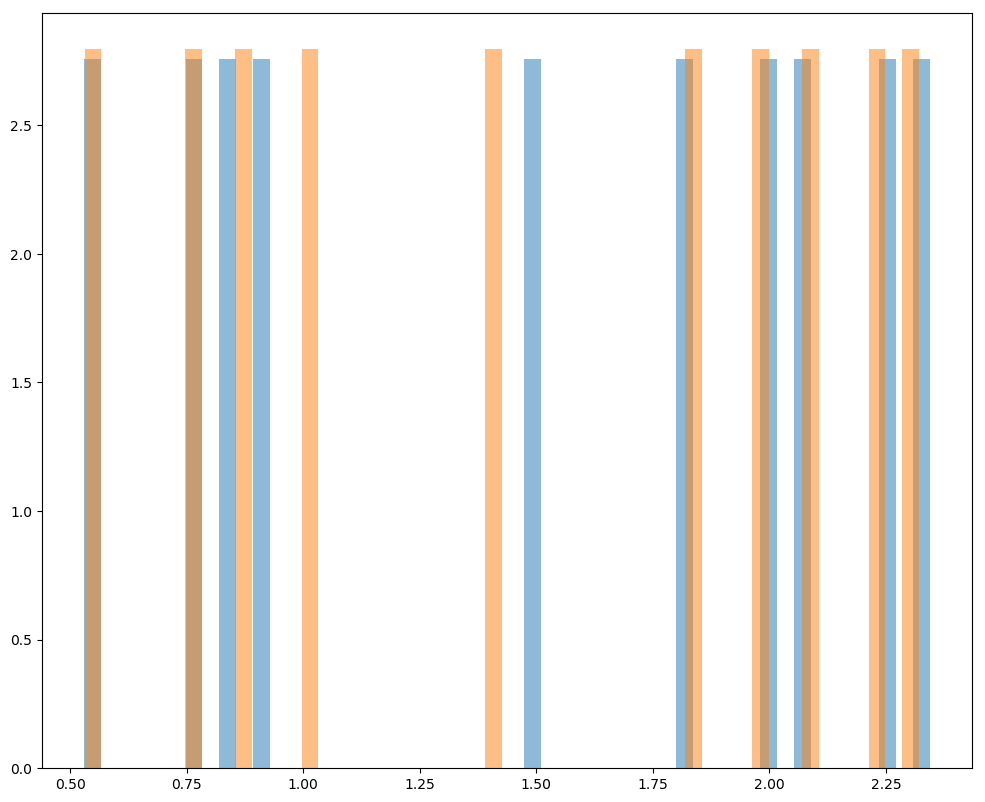

train and initial singular values distribution


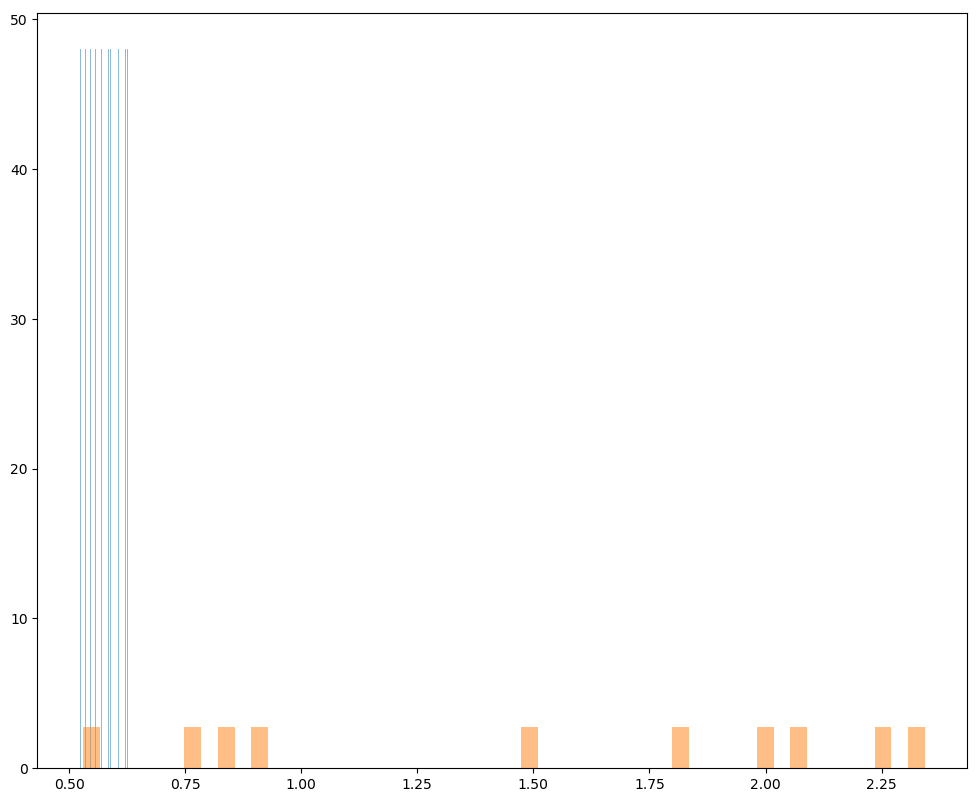

In [14]:
for i in range(2, 12, 2):
    print('index = ', i, list(model1.parameters())[i].shape)
    print('='*20)
    print('='*20)
    look_at_models(model1, model2, model3, model4, architecture, i)

distance between train models 53.56632
distance between initial models 101.51331
how far model1 go 81.007286
how far model2 go 80.623314
initial singular values
train singular values
initial singular values distribution


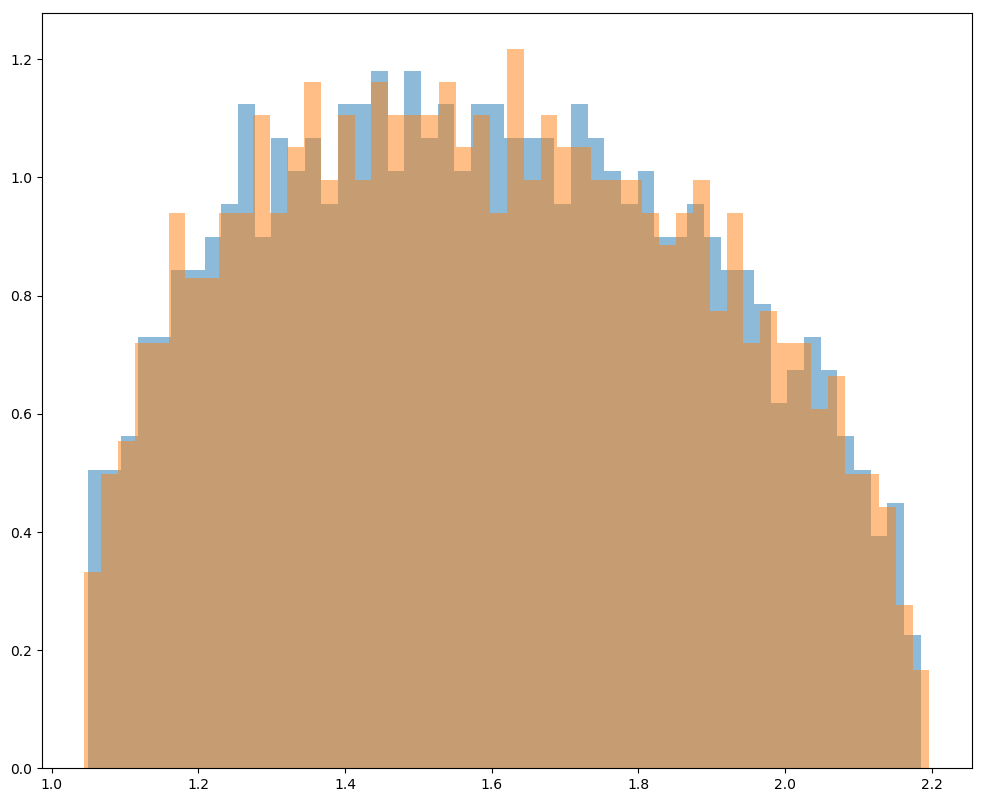

train singular values distribution


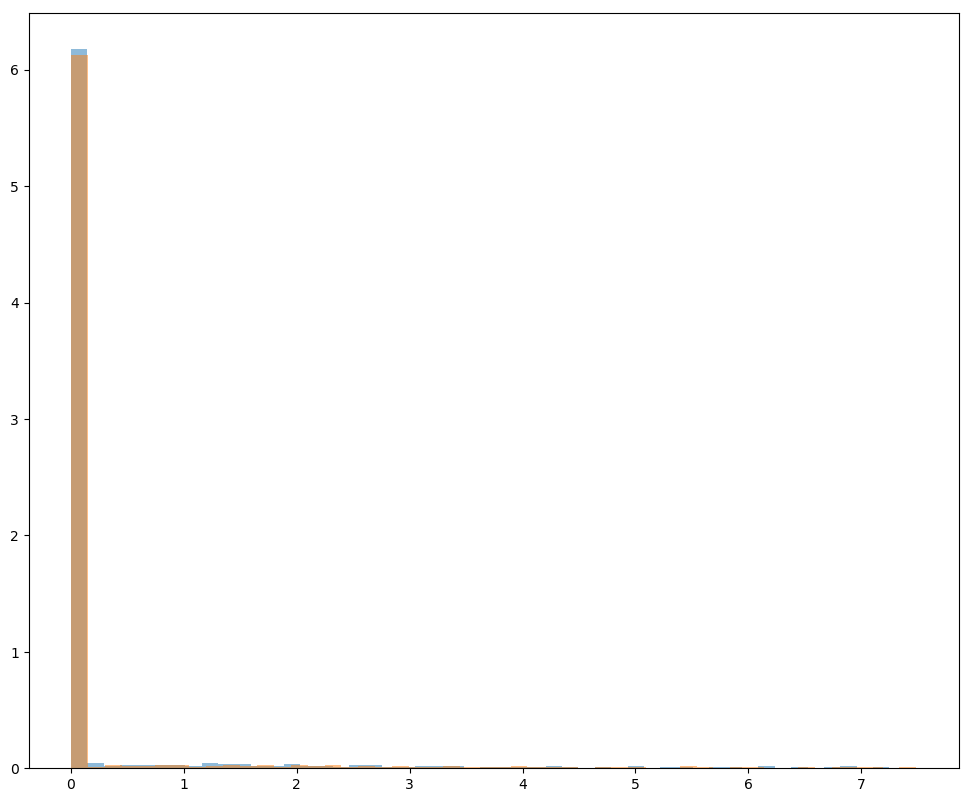

train and initial singular values distribution


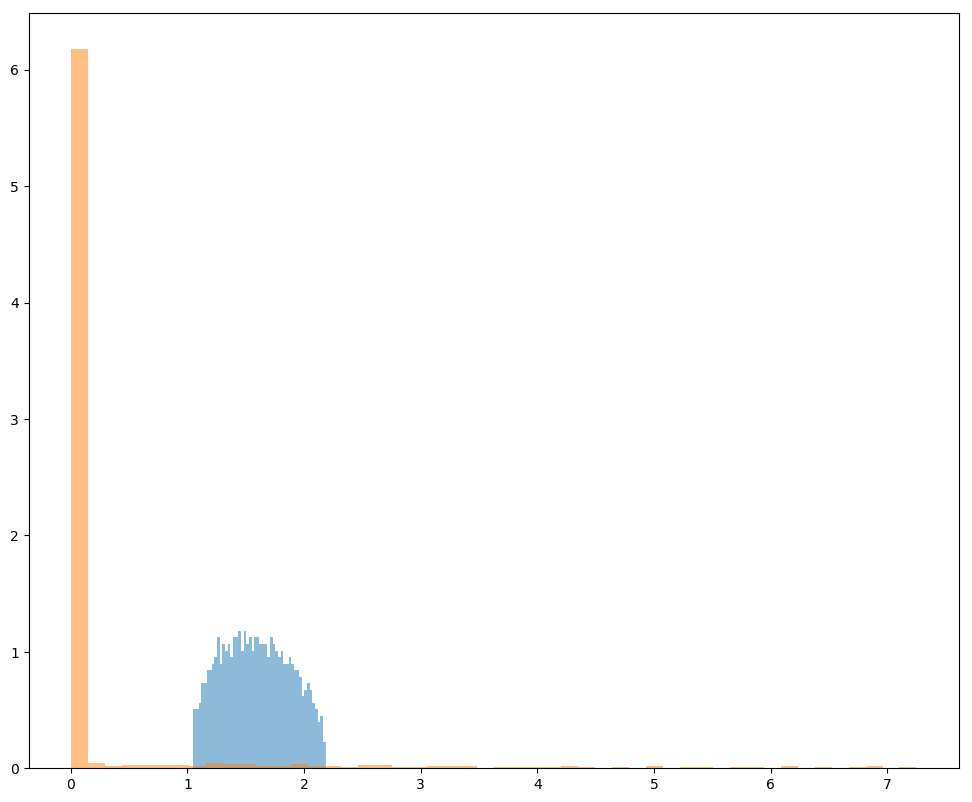

train models eigenvector heatmap


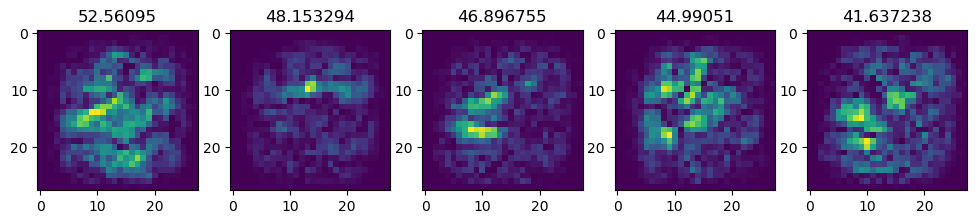

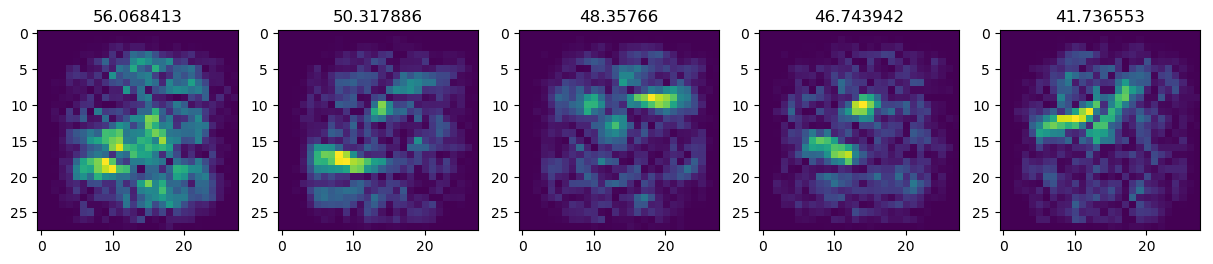

scalar product between train models
norms w1, w2 38.486153 37.679737
cos 0.010888865


In [23]:
model1.load_state_dict(torch.load('curves_mnist/Linear/Adam/curve1/checkpoint-20.pt')['model_state'])
model2.load_state_dict(torch.load('curves_mnist/Linear/Adam/curve2/checkpoint-20.pt')['model_state'])

model3.load_state_dict(torch.load('curves_mnist/Linear/Adam/curve1/checkpoint-0.pt')['model_state'])
model4.load_state_dict(torch.load('curves_mnist/Linear/Adam/curve2/checkpoint-0.pt')['model_state'])

look_at_models(model1, model2, model3, model4, architecture, 0)

index =  2 torch.Size([6144, 6144])
initial singular values
train singular values
initial singular values distribution


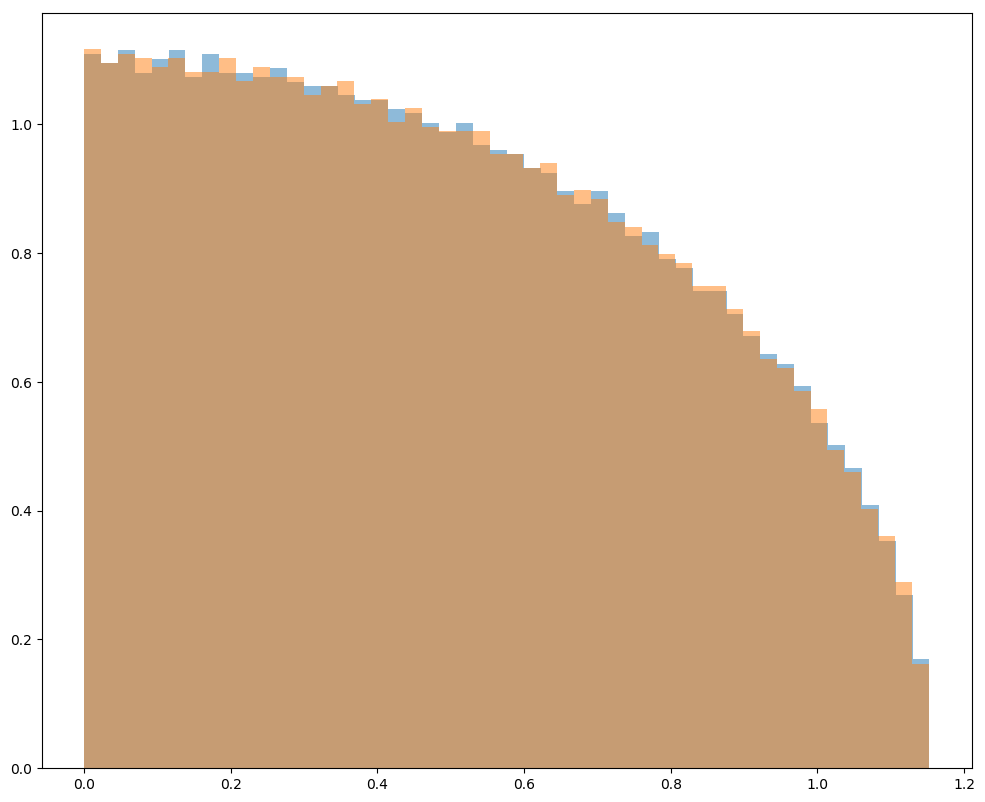

train singular values distribution


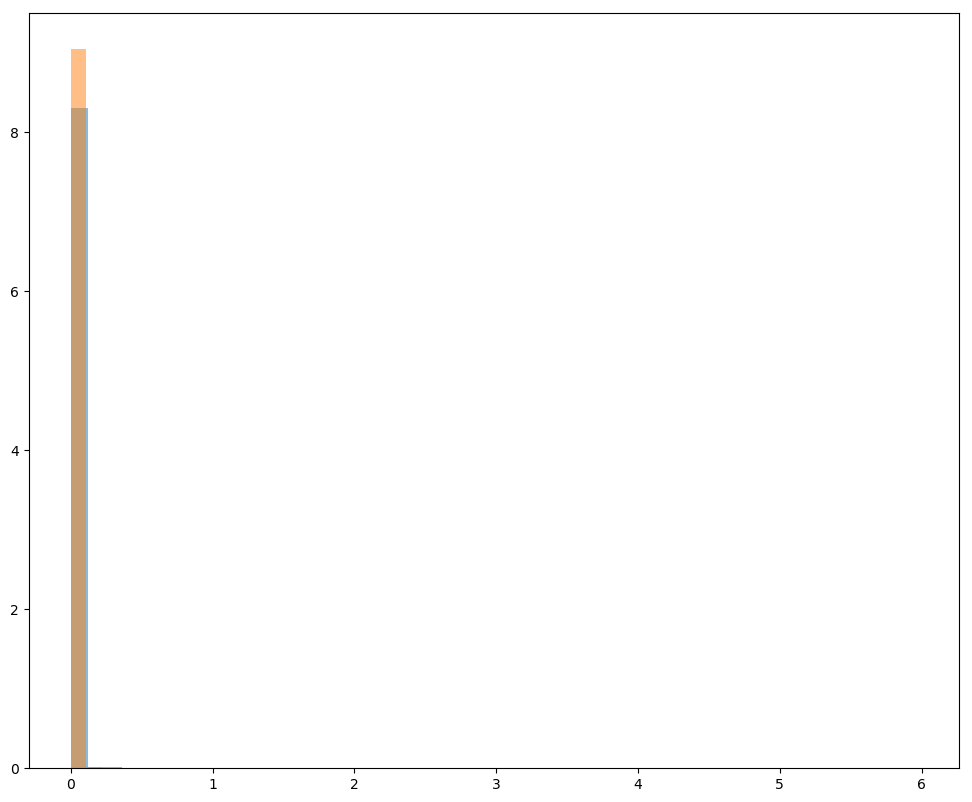

train and initial singular values distribution


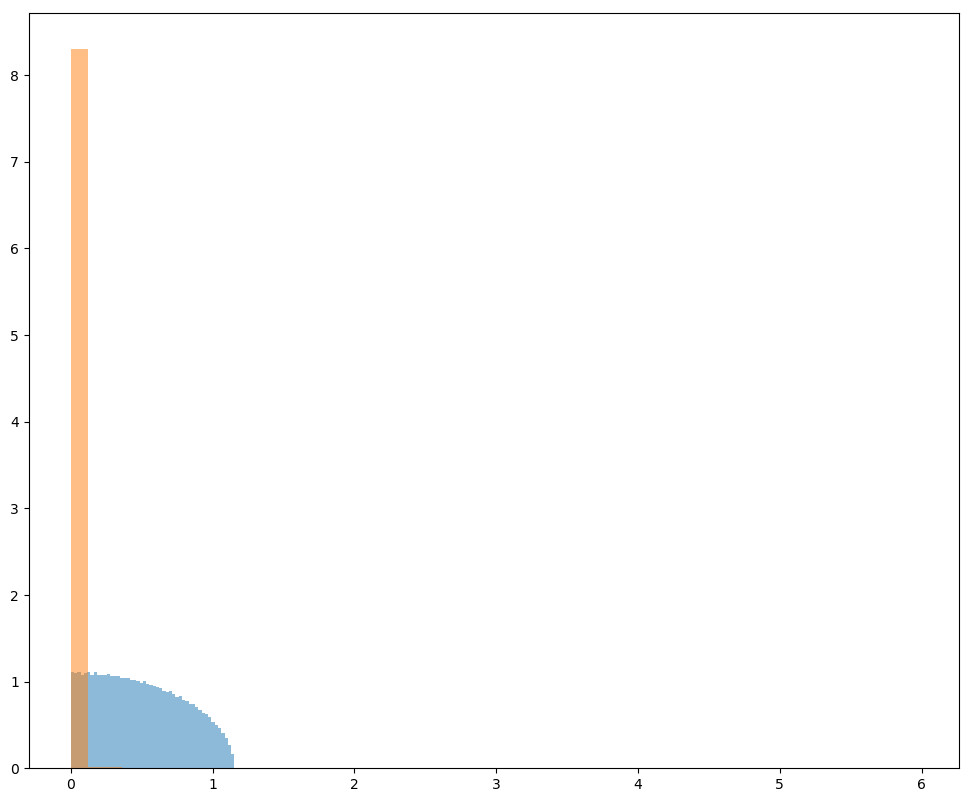

index =  4 torch.Size([1152, 6144])
initial singular values
train singular values
initial singular values distribution


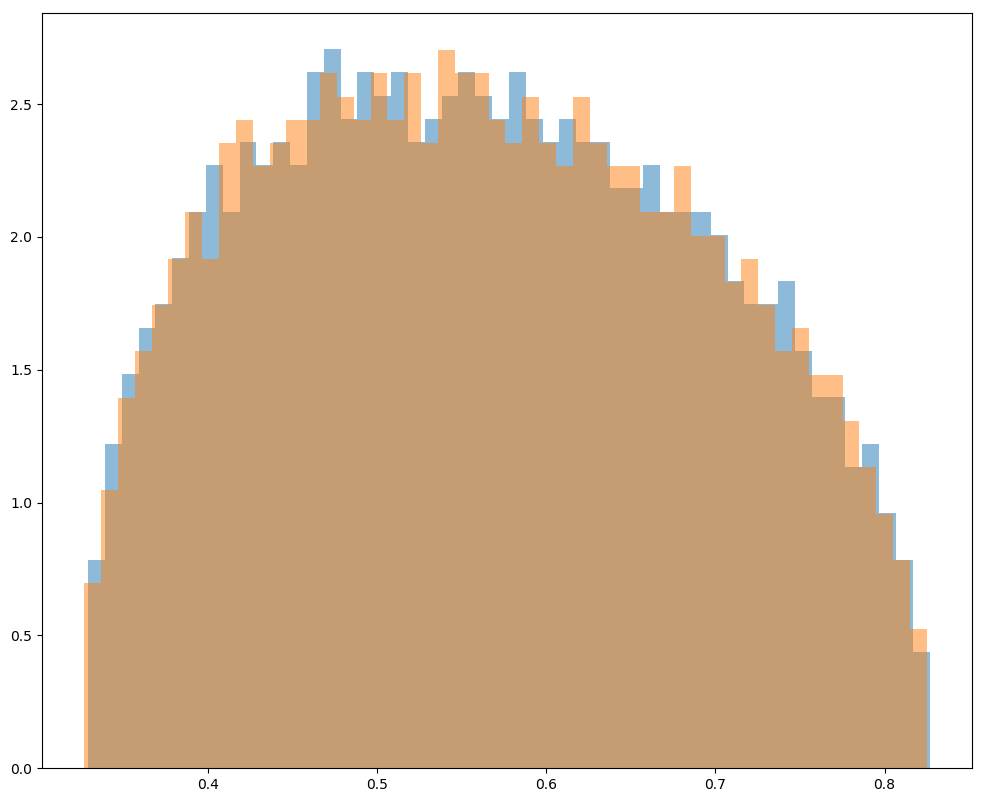

train singular values distribution


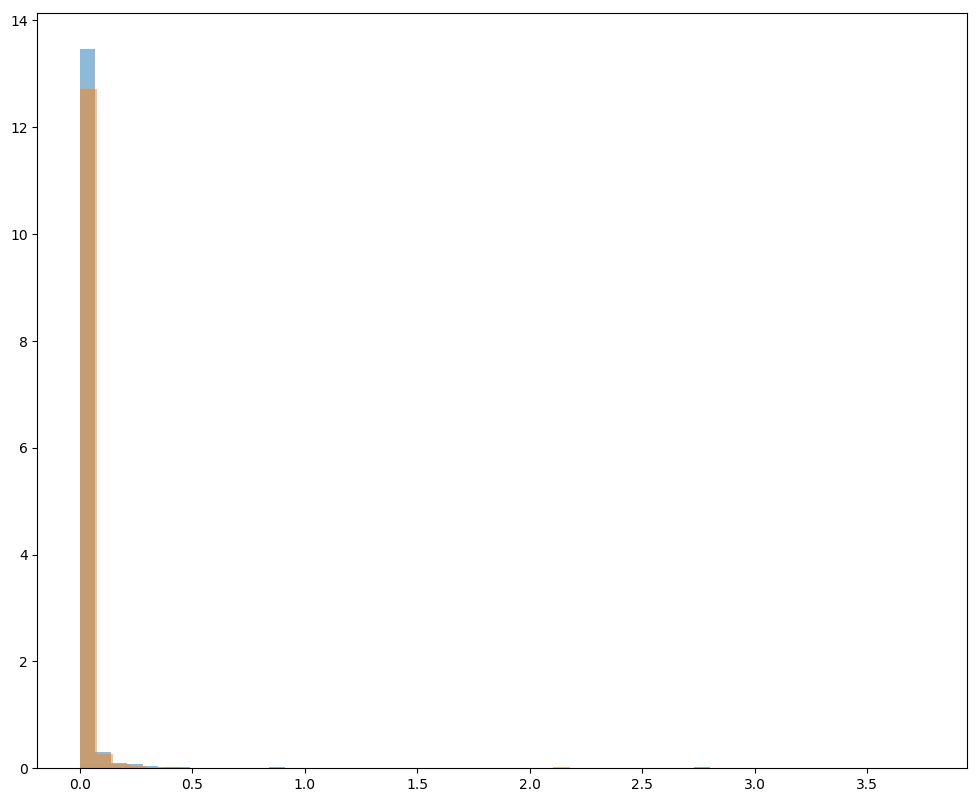

train and initial singular values distribution


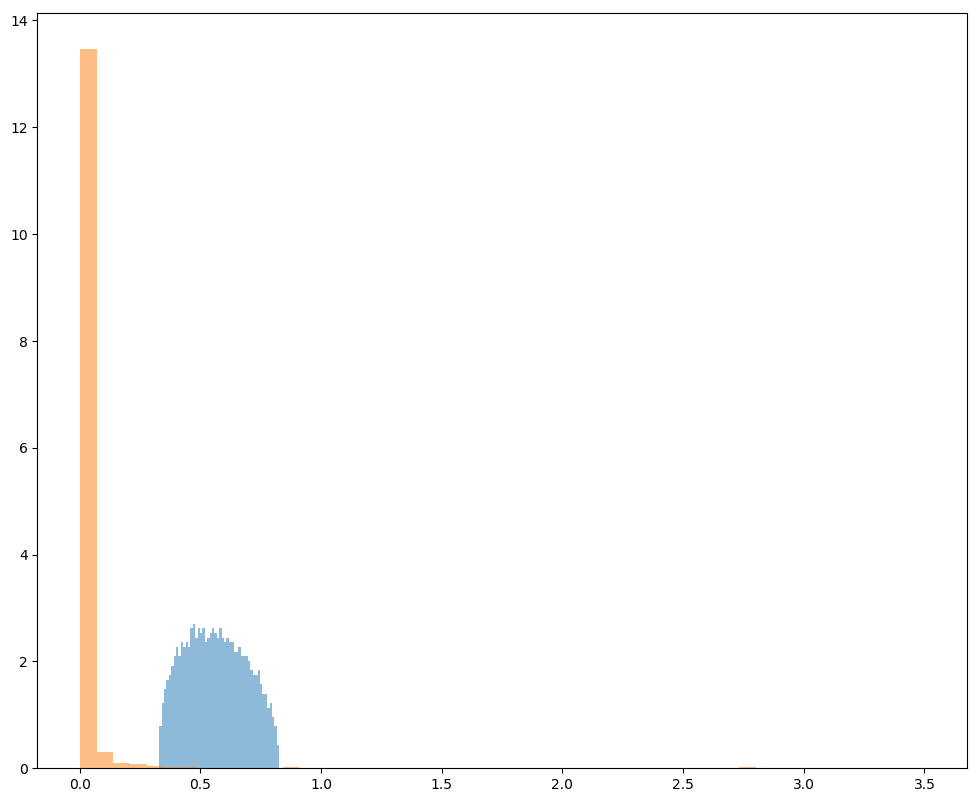

index =  6 torch.Size([1000, 1152])
initial singular values
train singular values
initial singular values distribution


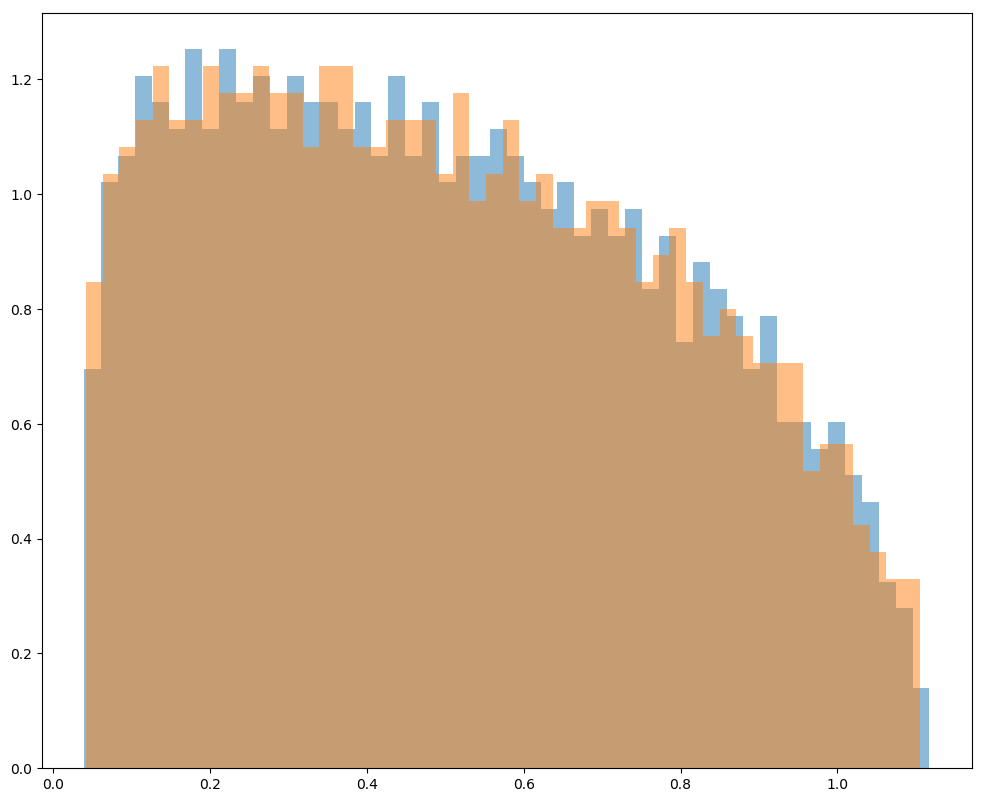

train singular values distribution


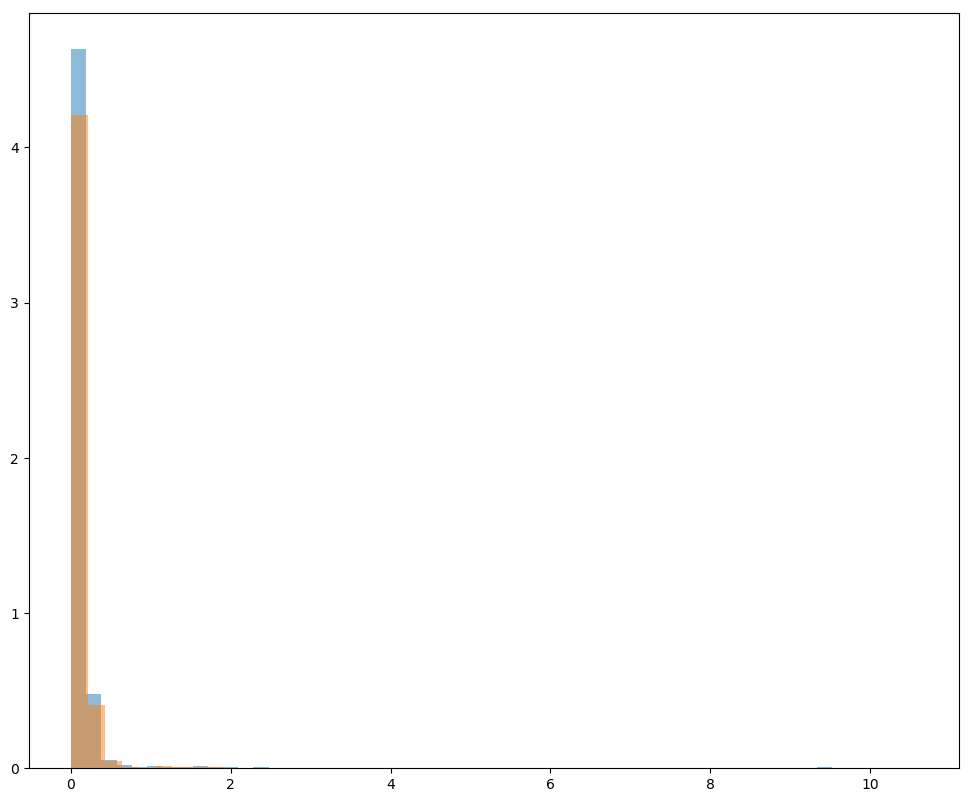

train and initial singular values distribution


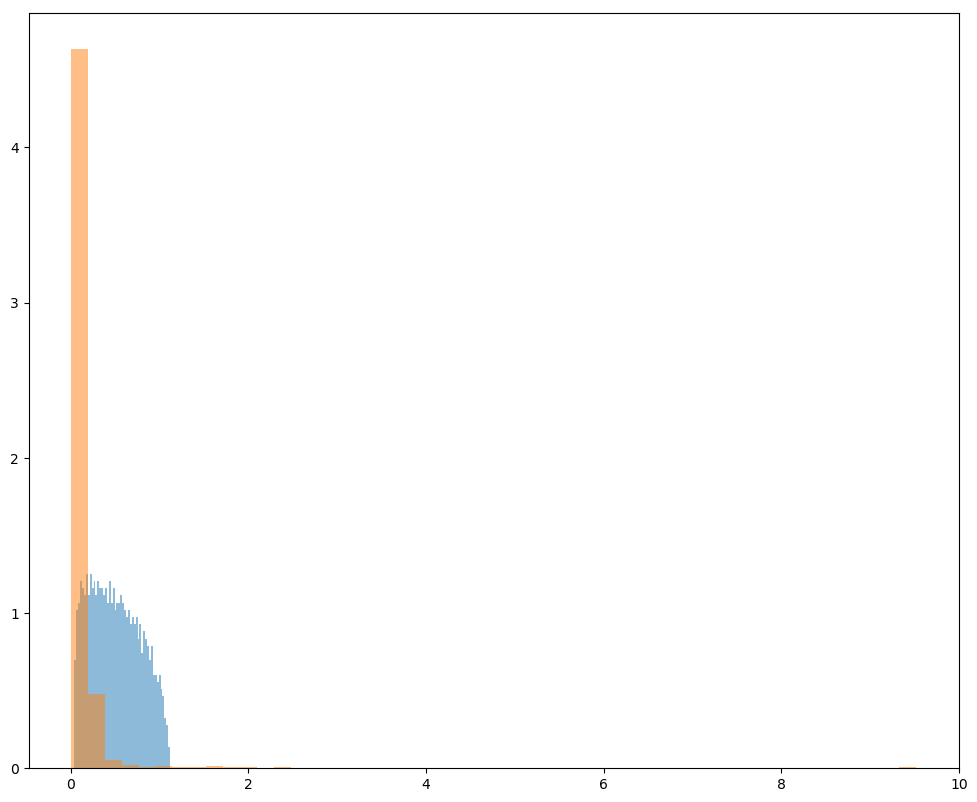

index =  8 torch.Size([1000, 1000])
initial singular values
train singular values
initial singular values distribution


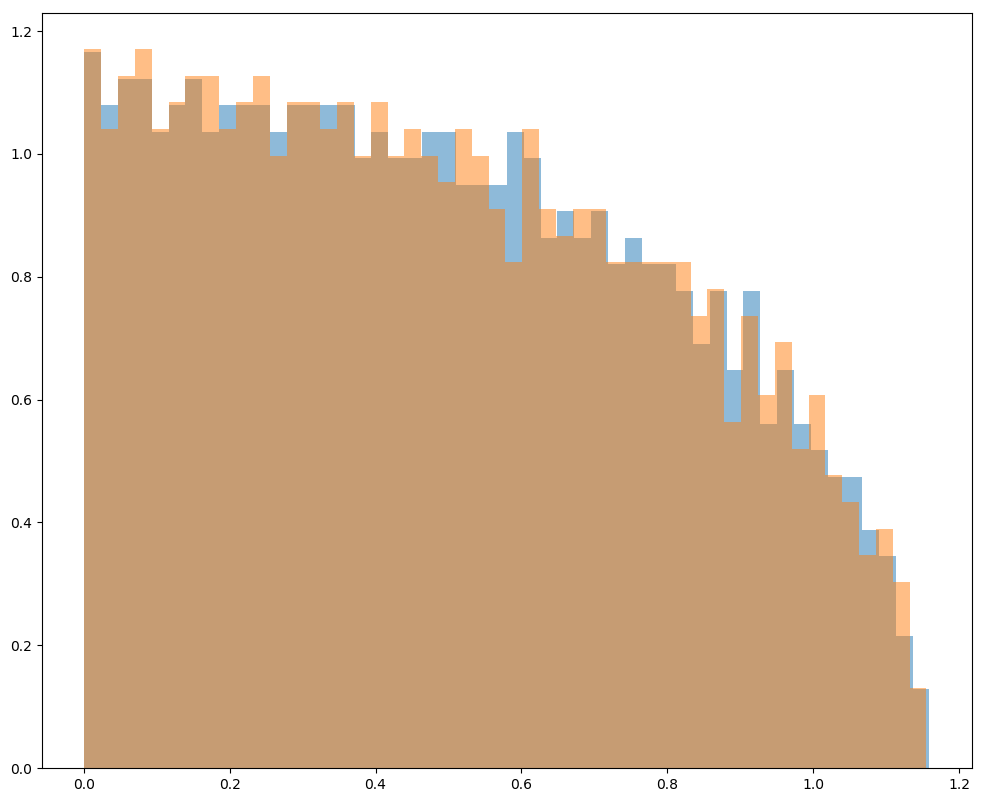

train singular values distribution


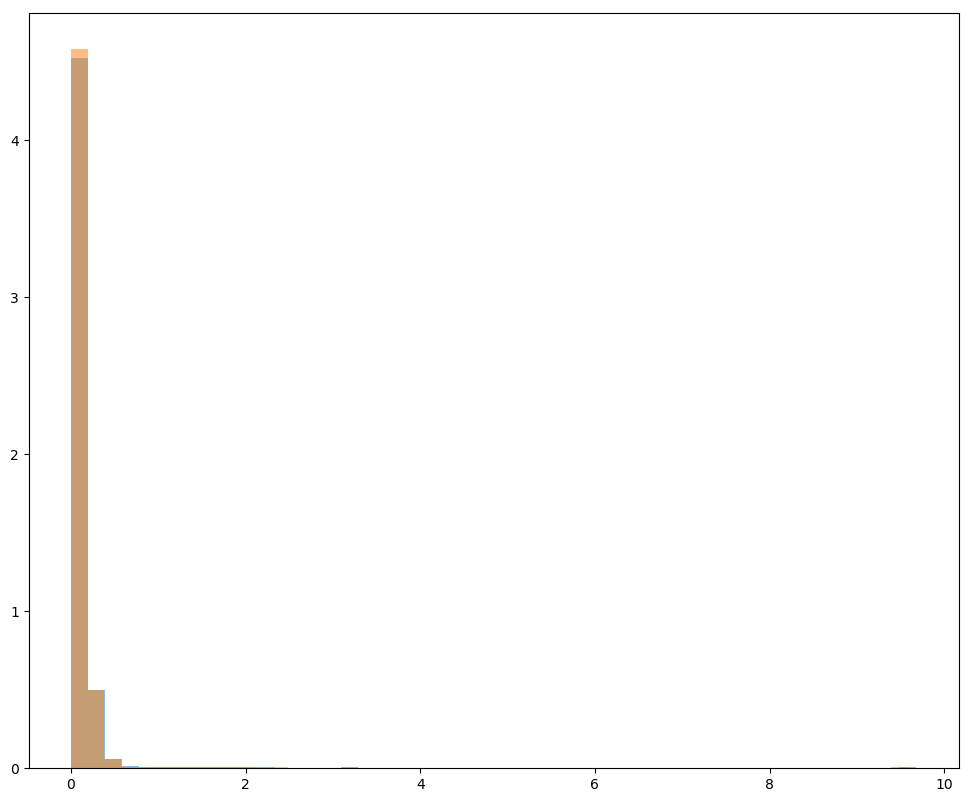

train and initial singular values distribution


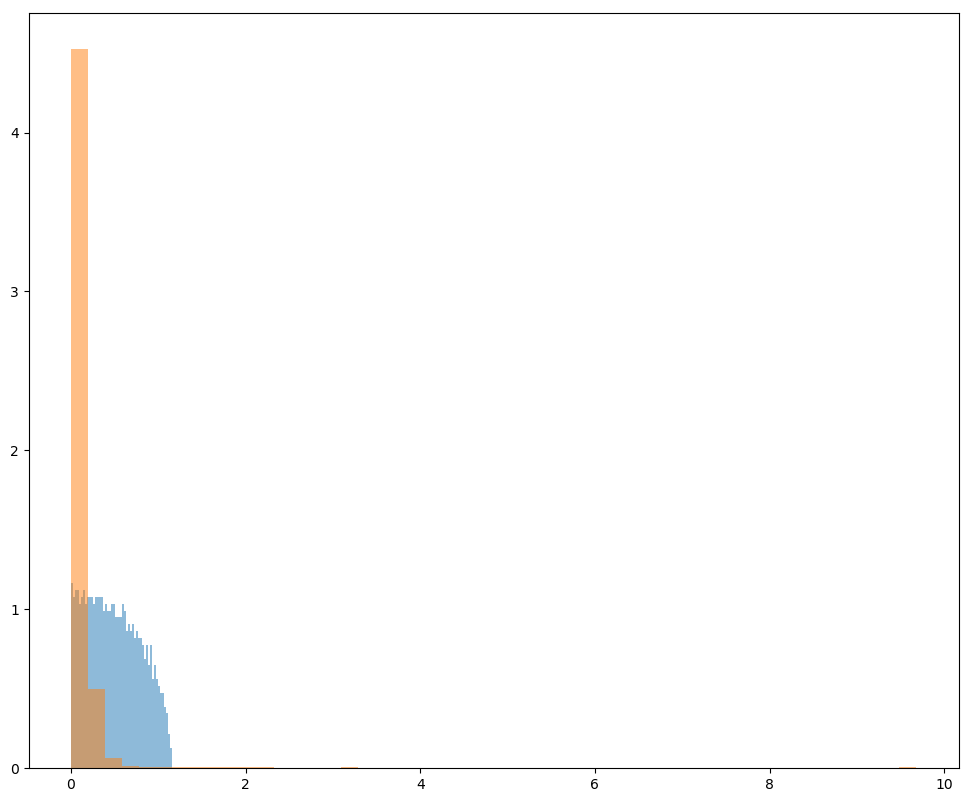

index =  10 torch.Size([10, 1000])
initial singular values
train singular values
initial singular values distribution


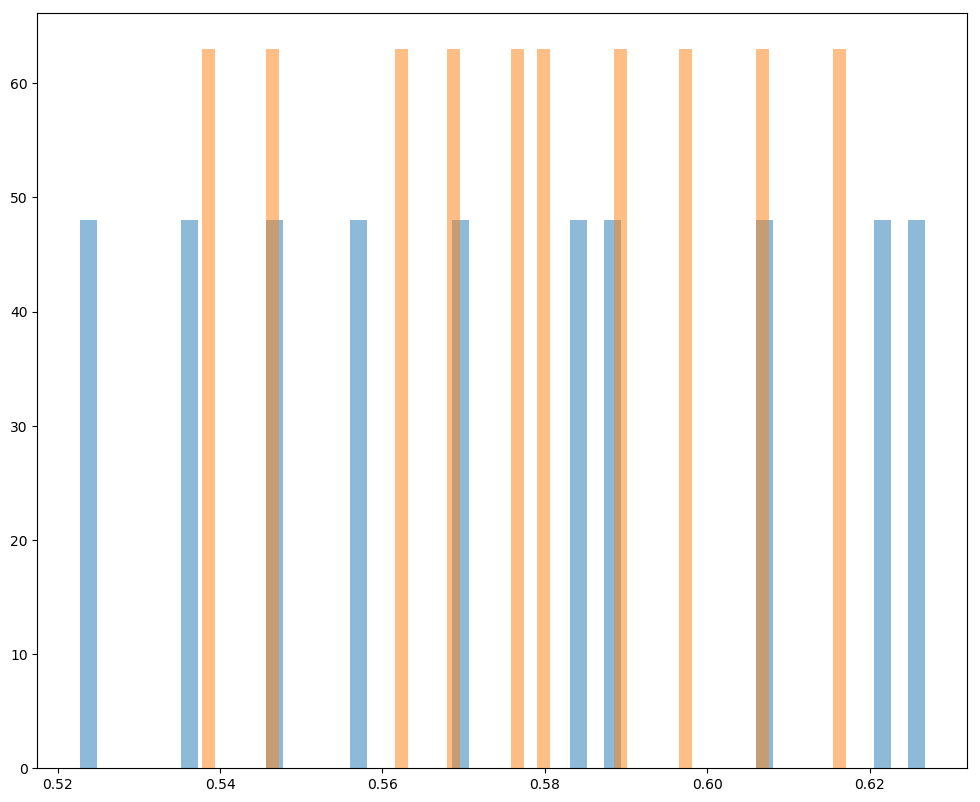

train singular values distribution


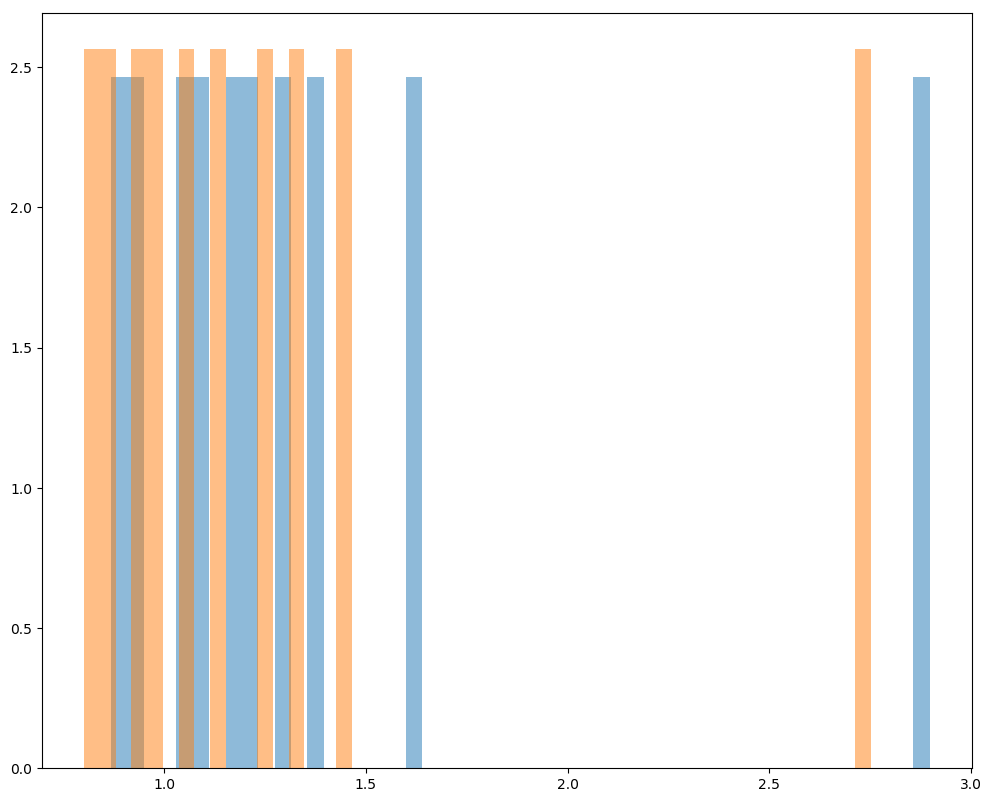

train and initial singular values distribution


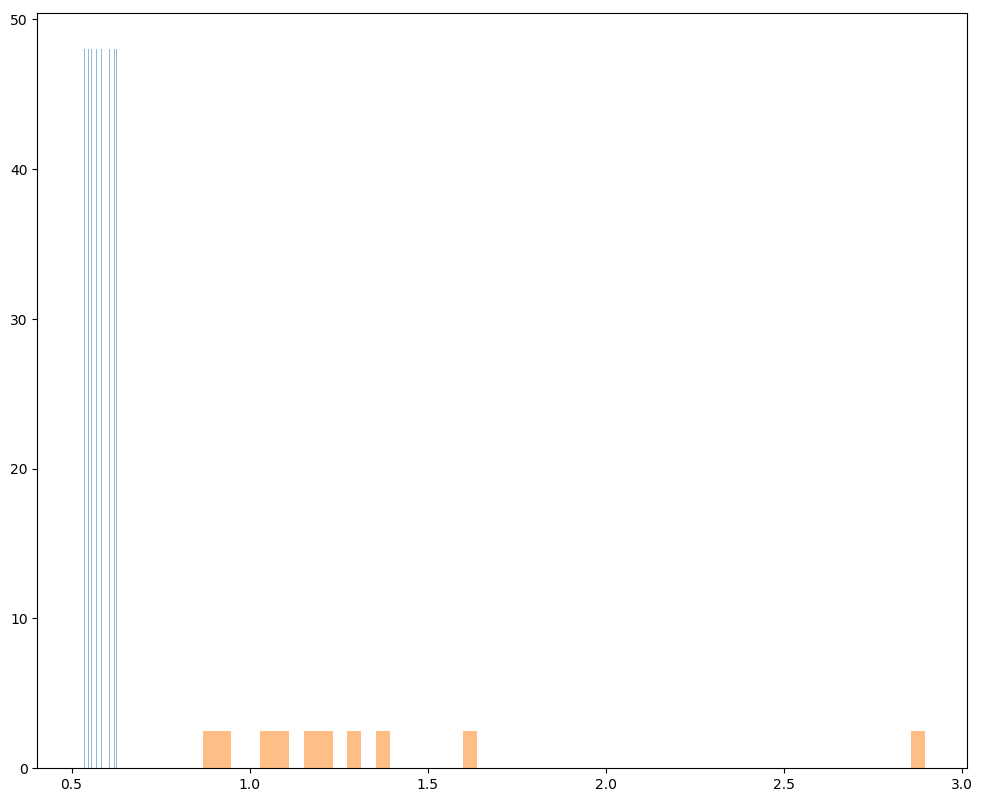

In [24]:
for i in range(2, 12, 2):
    print('index = ', i, list(model1.parameters())[i].shape)
    print('='*20)
    print('='*20)
    look_at_models(model1, model2, model3, model4, architecture, i)

In [57]:
W = list(model1.parameters())[2].cpu().data.numpy()

In [58]:
W = np.abs(W)>0.1

In [59]:
W[W.sum(-1)>0].sum(-1)

array([ 9,  1,  2, 14,  2,  2, 52, 21,  3, 64, 54, 57,  2,  5,  1,  1, 25,
        2,  3,  1,  1,  6,  3, 15, 23, 48,  2,  1,  3,  2, 23,  1,  1, 13,
        2, 43,  1,  4,  1,  3,  4,  2,  3,  1,  3,  2,  1, 33,  3,  1, 52,
       62,  3, 53,  1,  2, 30,  1, 37,  1,  2, 71,  1, 42,  3, 31,  1,  1,
       14, 58,  3,  2,  1,  5, 37,  2,  2, 55, 12,  2,  4, 11, 69,  9,  2,
        2,  1, 48,  5, 56,  1, 48,  7, 67,  1,  3,  1,  2,  1,  1, 39,  2,
        1,  2, 59,  5, 58, 49,  1,  1, 44, 63,  1, 24,  1, 42,  2,  2,  3,
       43, 34,  1,  1,  7, 44,  2, 48, 33,  3,  3,  2,  1, 33, 64, 35])

In [60]:
# rcParams['figure.dpi'] = 600
# plt.imshow(W)
# plt.colorbar()

In [61]:
loaders, num_classes = data.loaders(
    "CIFAR10",
    "data",
    128,
    1,
    "VGG",
    True)

criterion = F.cross_entropy
regularizer = None 

architecture = getattr(models, "Linear") #LinearOneLayer LogRegression
model1 = architecture.base(num_classes=10, **architecture.kwargs)
model2 = architecture.base(num_classes=10, **architecture.kwargs)
model3 = architecture.base(num_classes=10, **architecture.kwargs)
model4 = architecture.base(num_classes=10, **architecture.kwargs)

model1.load_state_dict(torch.load('curves_linear/curve1/checkpoint-100.pt')['model_state'])
model2.load_state_dict(torch.load('curves_linear/curve2/checkpoint-100.pt')['model_state'])

model3.load_state_dict(torch.load('curves_linear/curve1/checkpoint-0.pt')['model_state'])
model4.load_state_dict(torch.load('curves_linear/curve2/checkpoint-0.pt')['model_state'])

# look_at_models(model1, model2, model3, model4, architecture)

Files already downloaded and verified
You are going to run models on the test set. Are you sure?
Files already downloaded and verified


distance between train models 106.30477
distance between initial models 101.49703
how far model1 go 50.3393
how far model2 go 50.36756
initial singular values
train singular values
initial singular values distribution


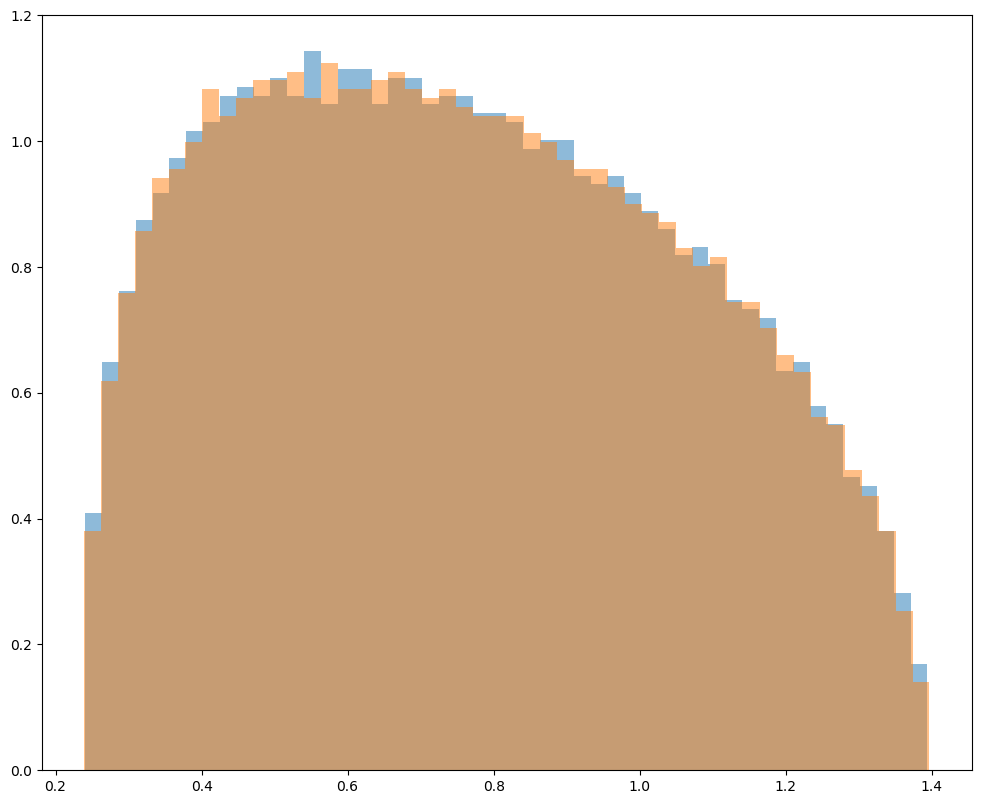

train singular values distribution


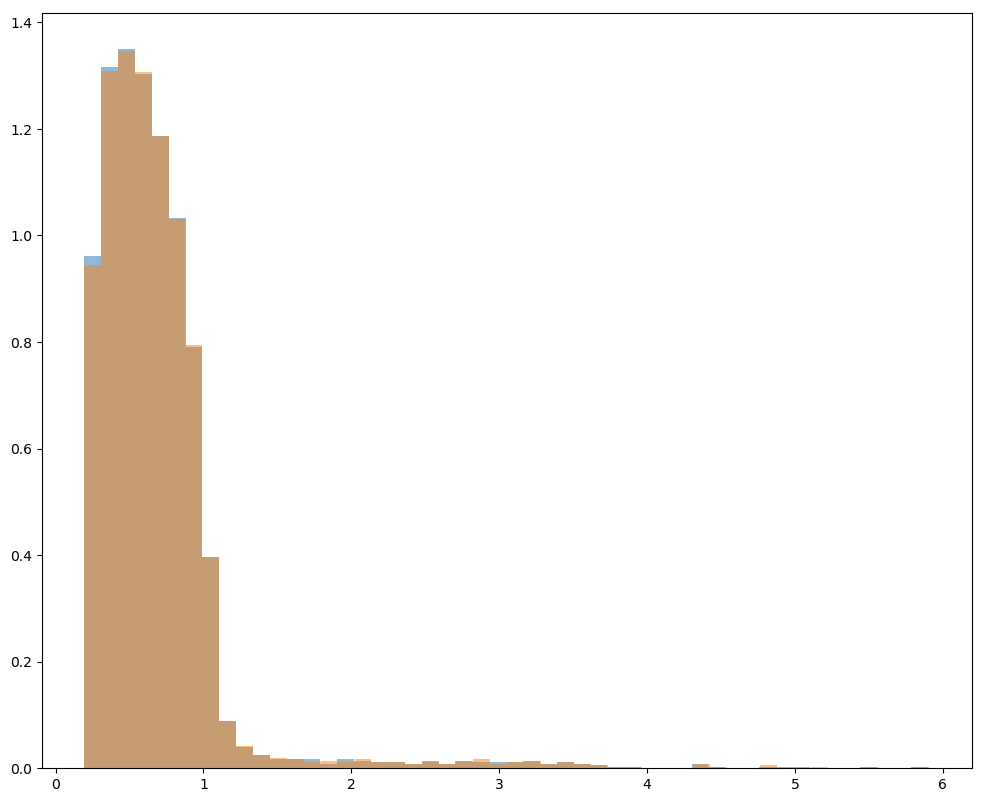

train and initial singular values distribution


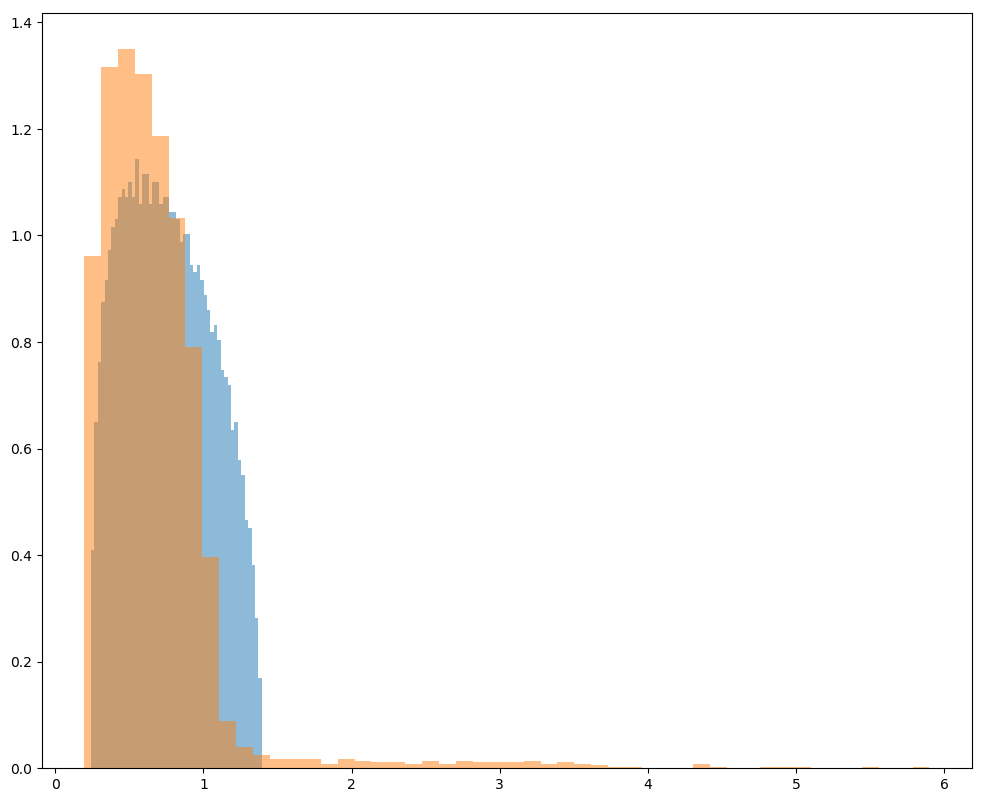

train models eigenvector heatmap


ValueError: cannot reshape array of size 3072 into shape (28,28)

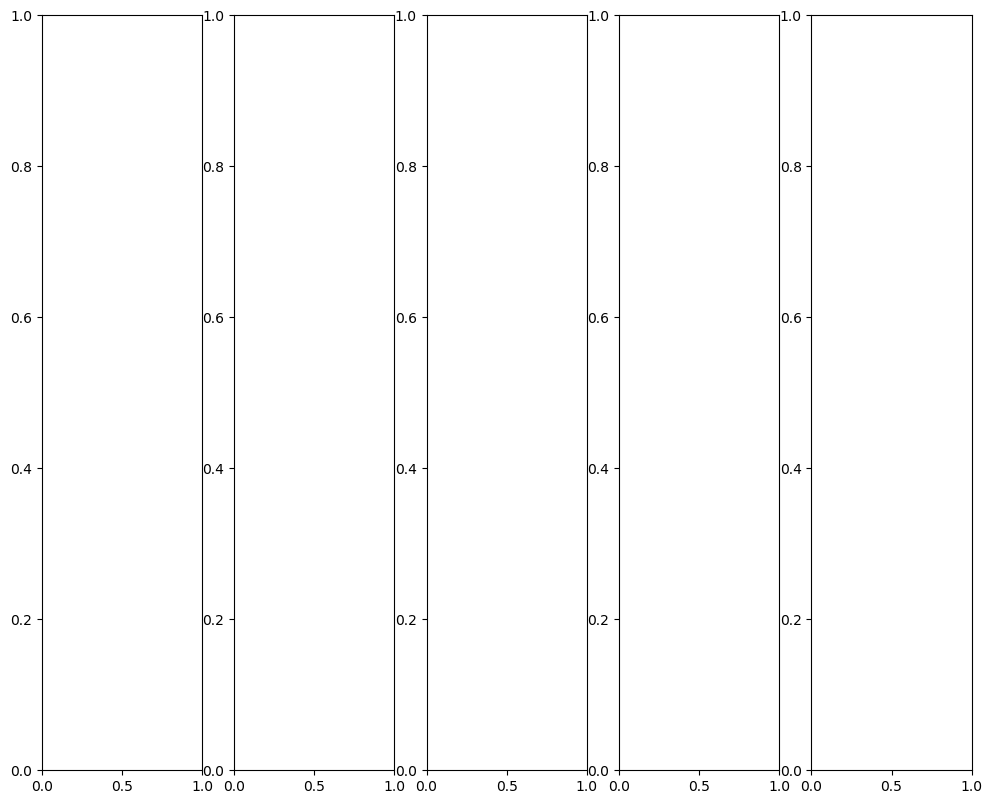

In [62]:
look_at_models(model1, model2, model3, model4, architecture, 0)

index =  2 torch.Size([6144, 6144])
initial singular values
train singular values
initial singular values distribution


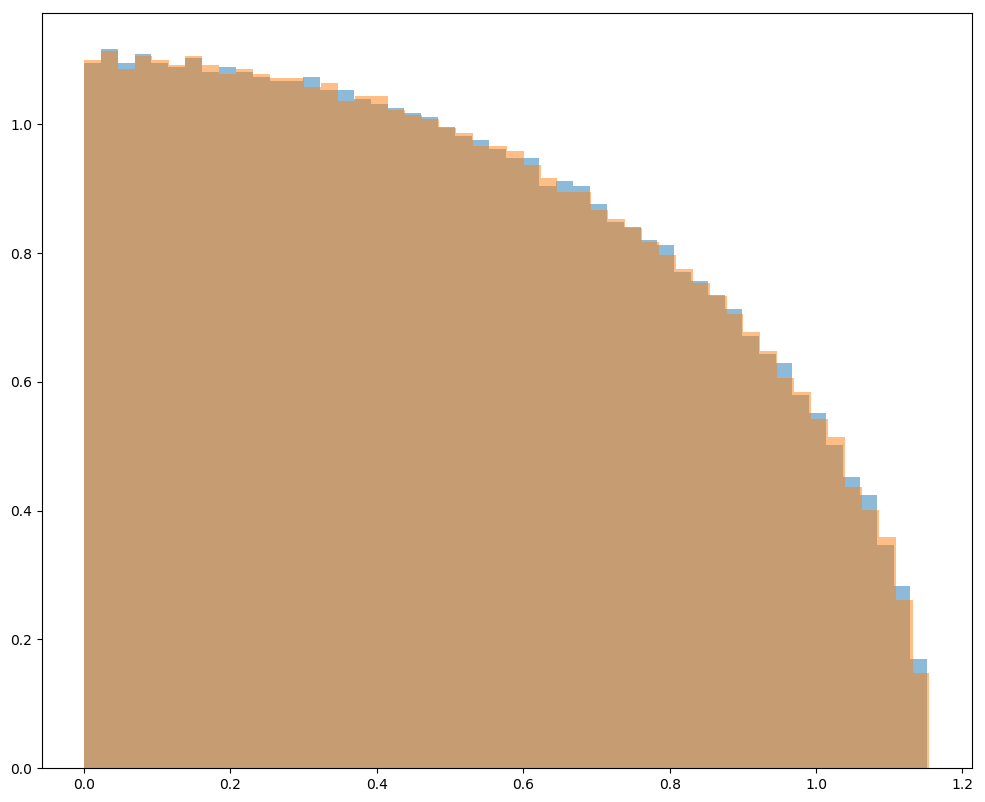

train singular values distribution


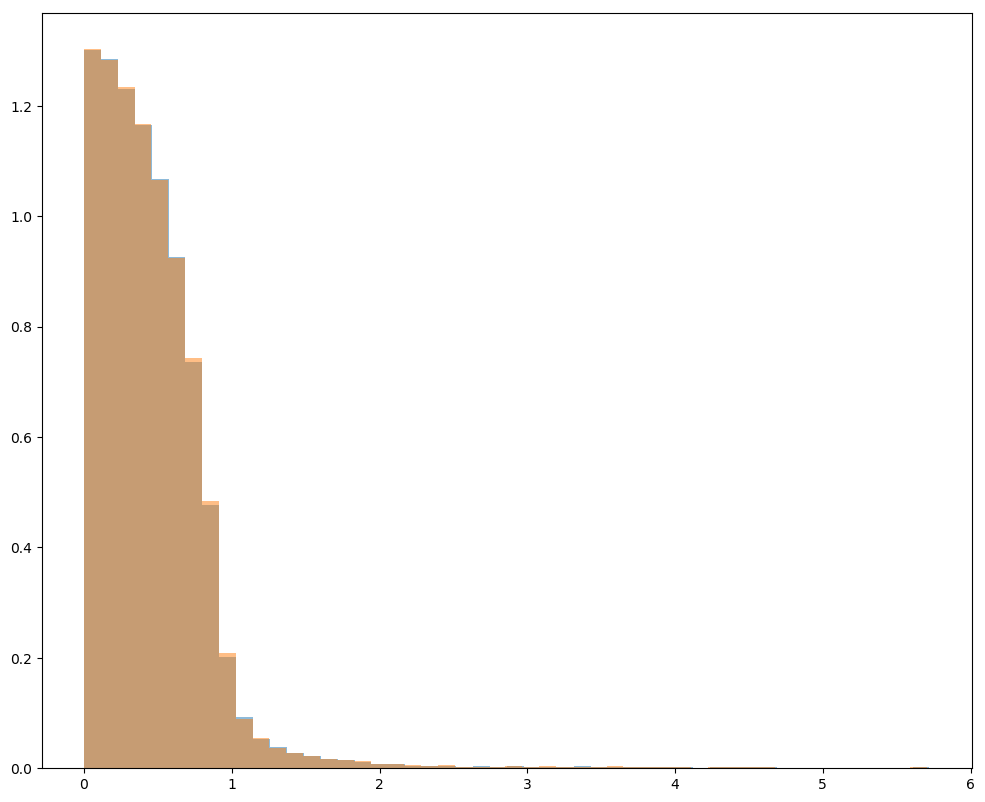

train and initial singular values distribution


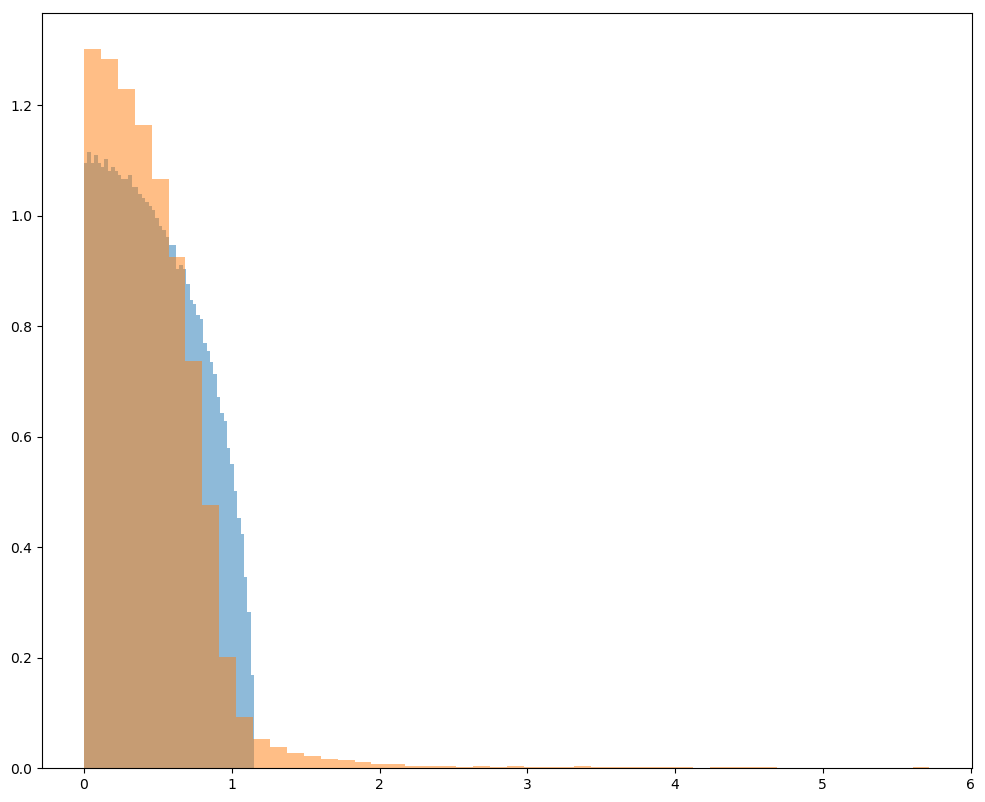

index =  4 torch.Size([1152, 6144])
initial singular values
train singular values
initial singular values distribution


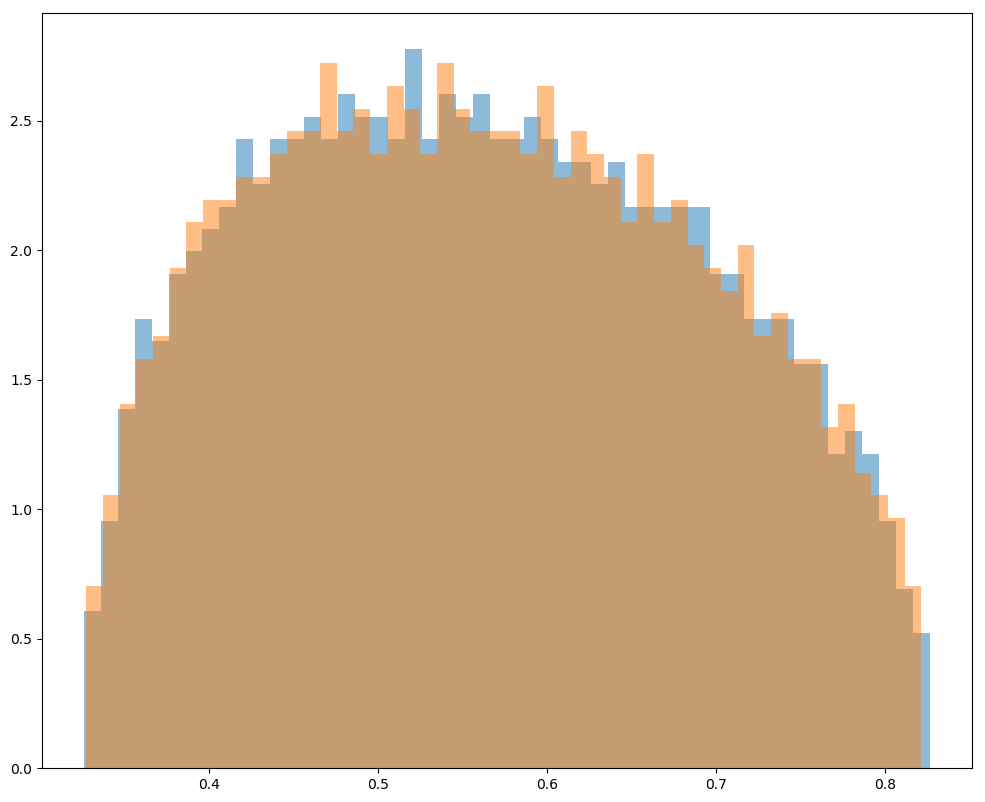

train singular values distribution


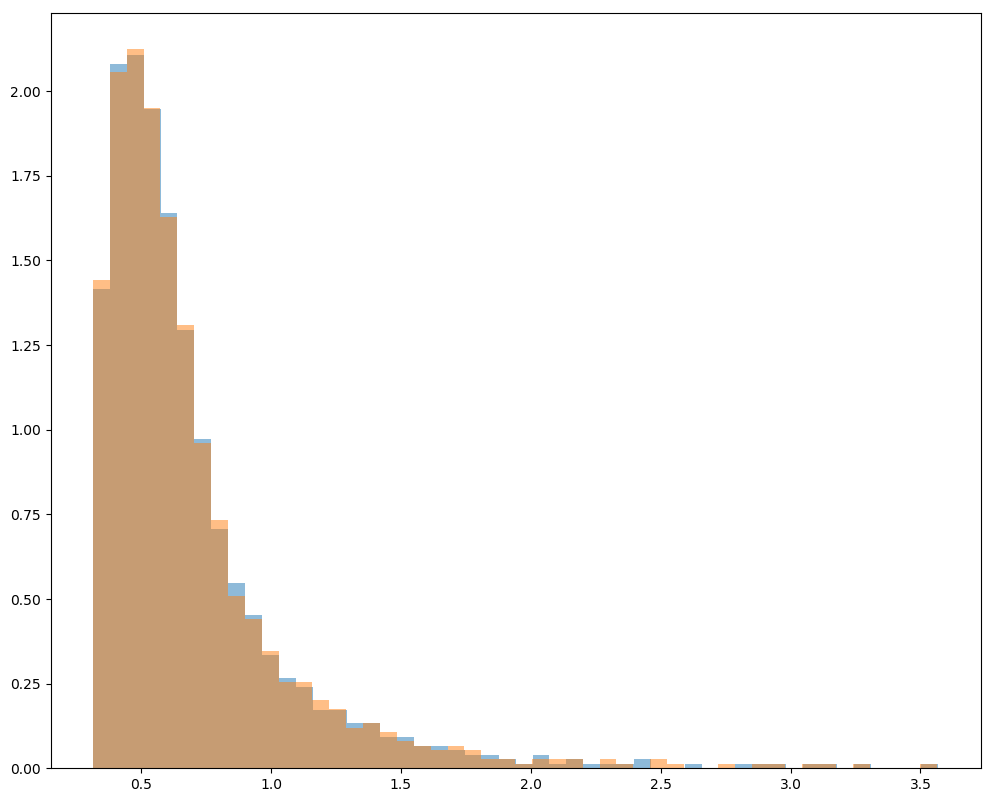

train and initial singular values distribution


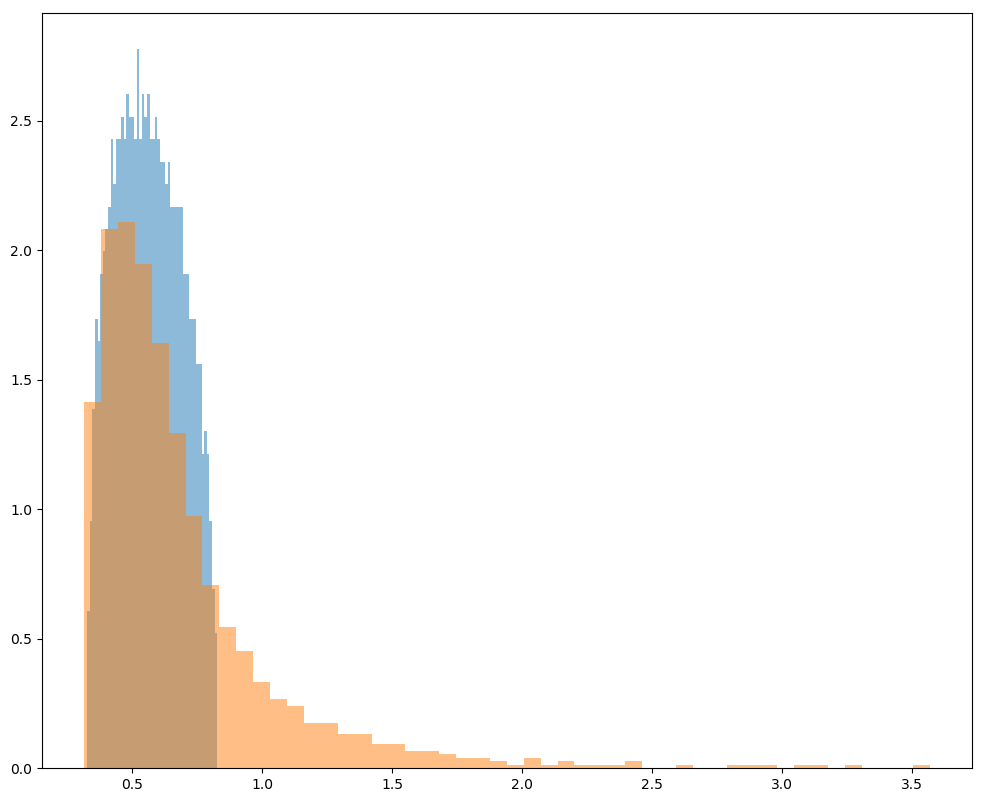

index =  6 torch.Size([1000, 1152])
initial singular values
train singular values
initial singular values distribution


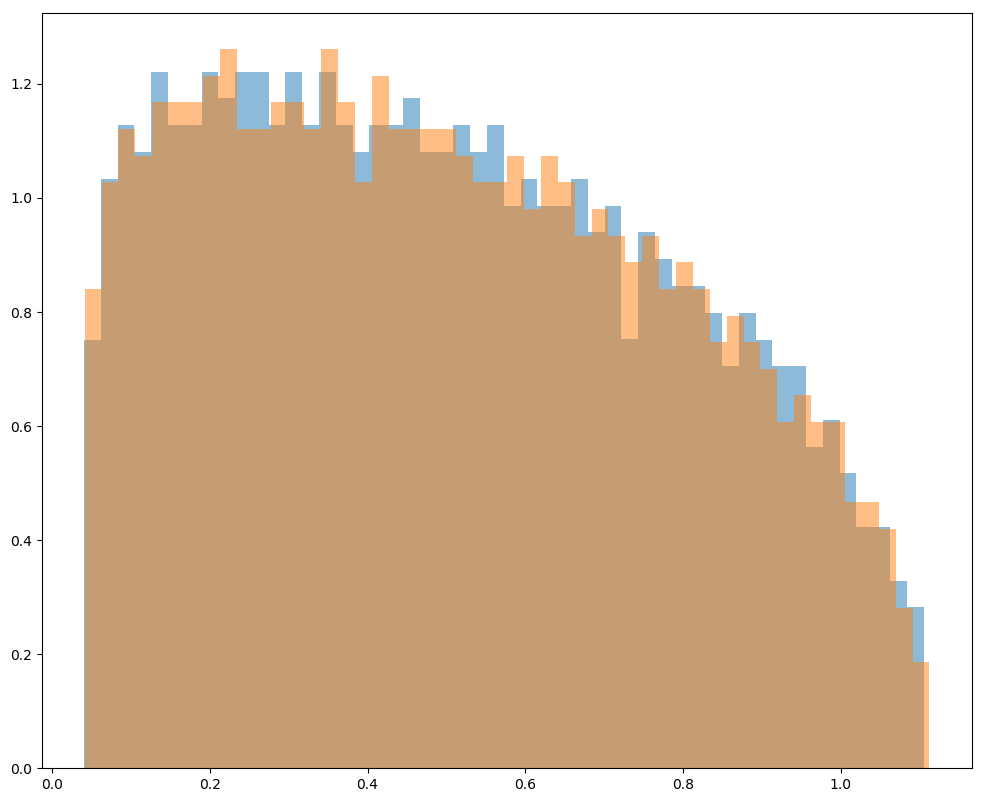

train singular values distribution


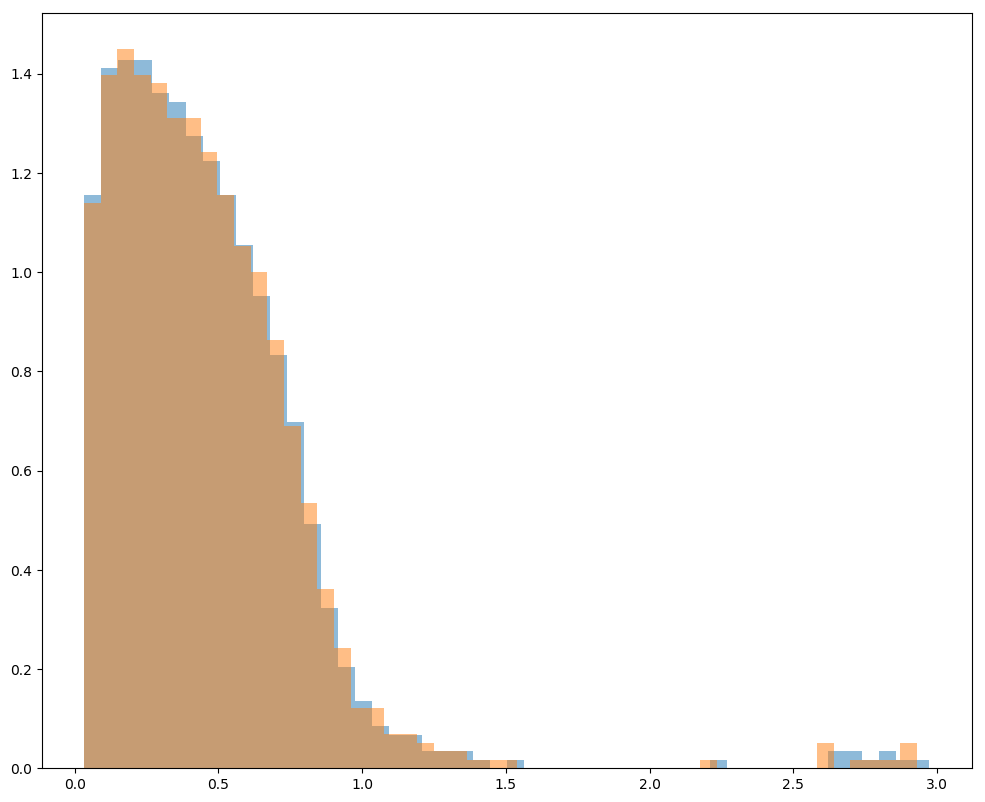

train and initial singular values distribution


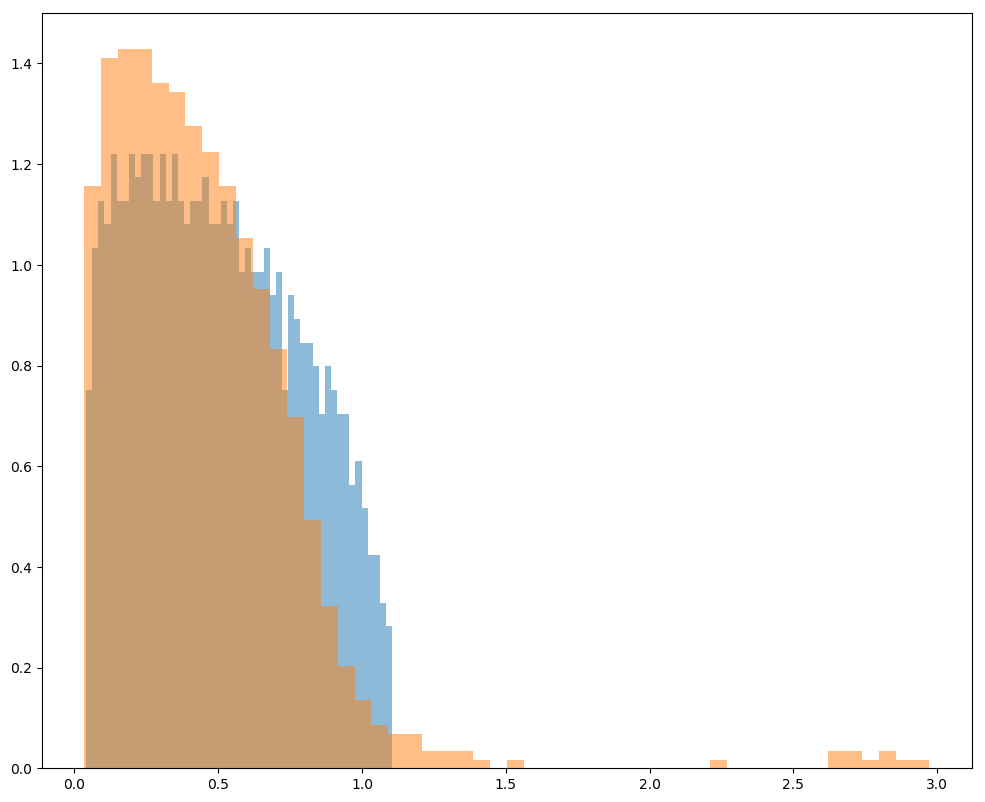

index =  8 torch.Size([1000, 1000])
initial singular values
train singular values
initial singular values distribution


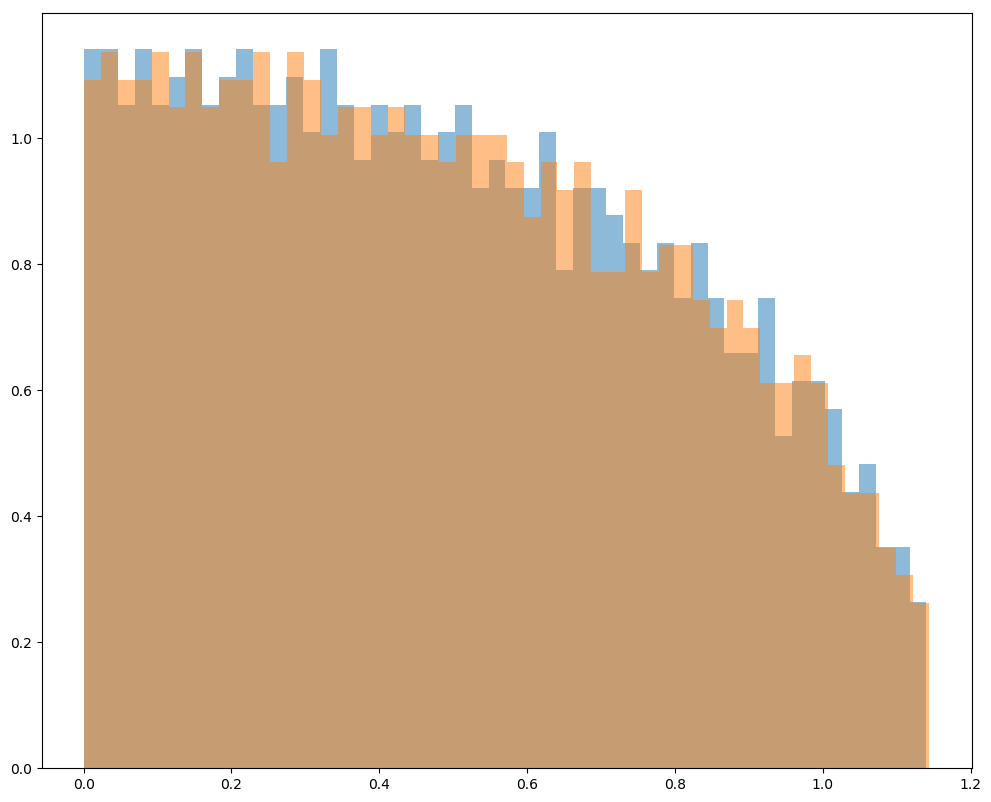

train singular values distribution


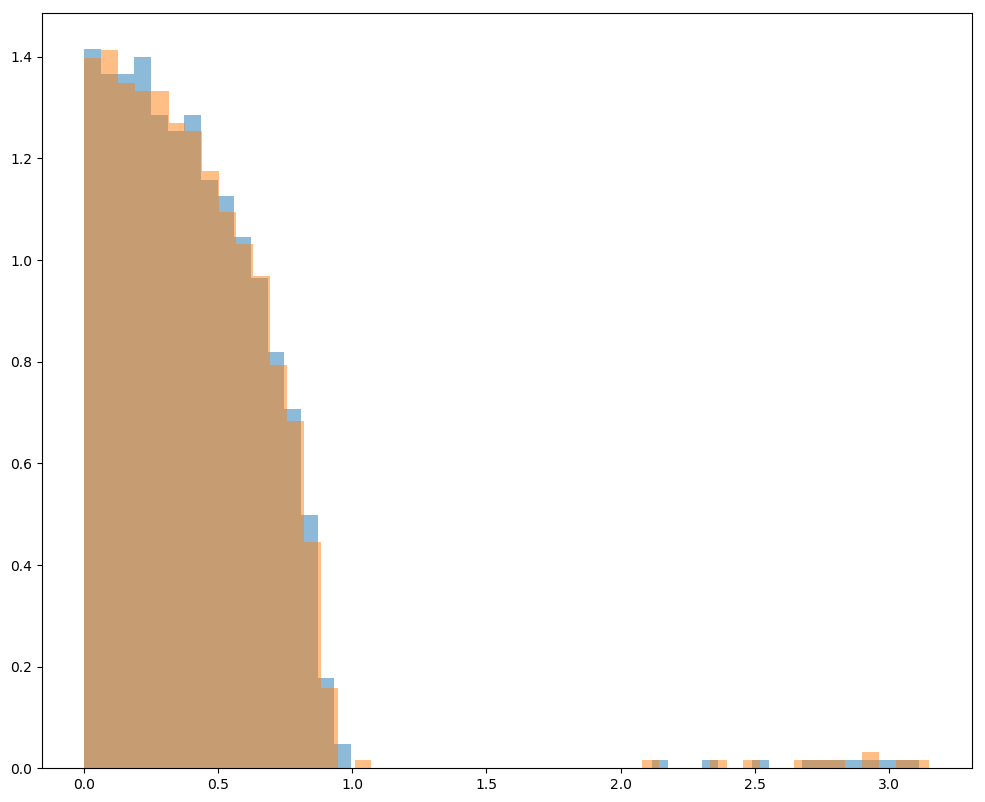

train and initial singular values distribution


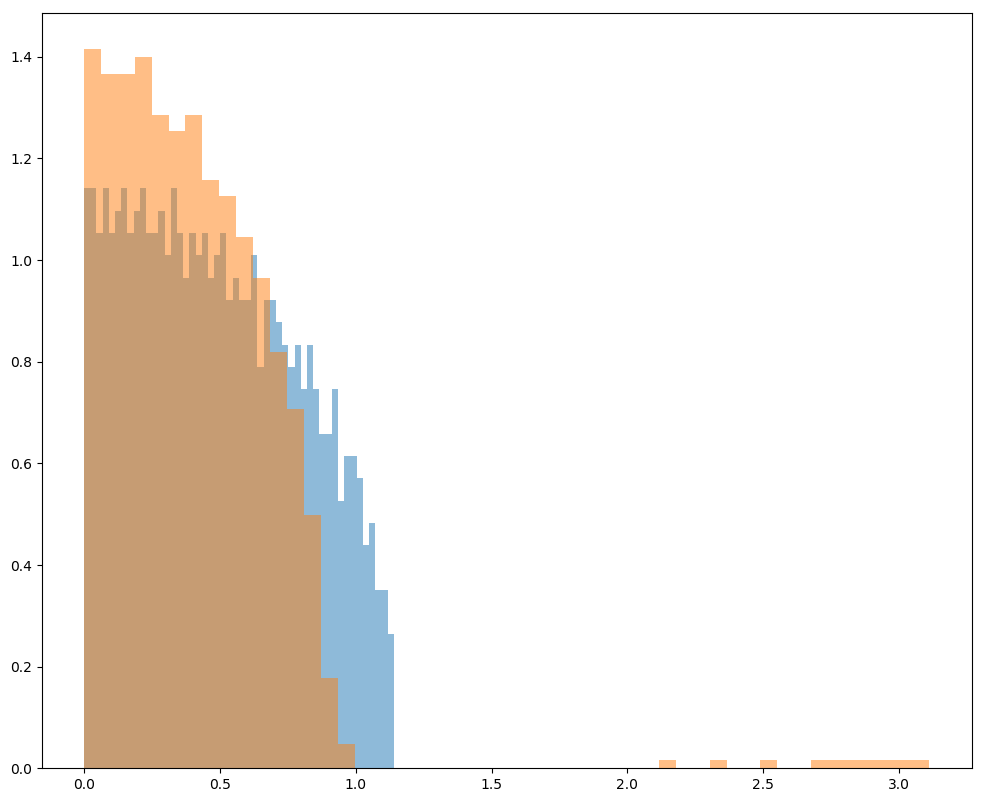

index =  10 torch.Size([10, 1000])
initial singular values
train singular values
initial singular values distribution


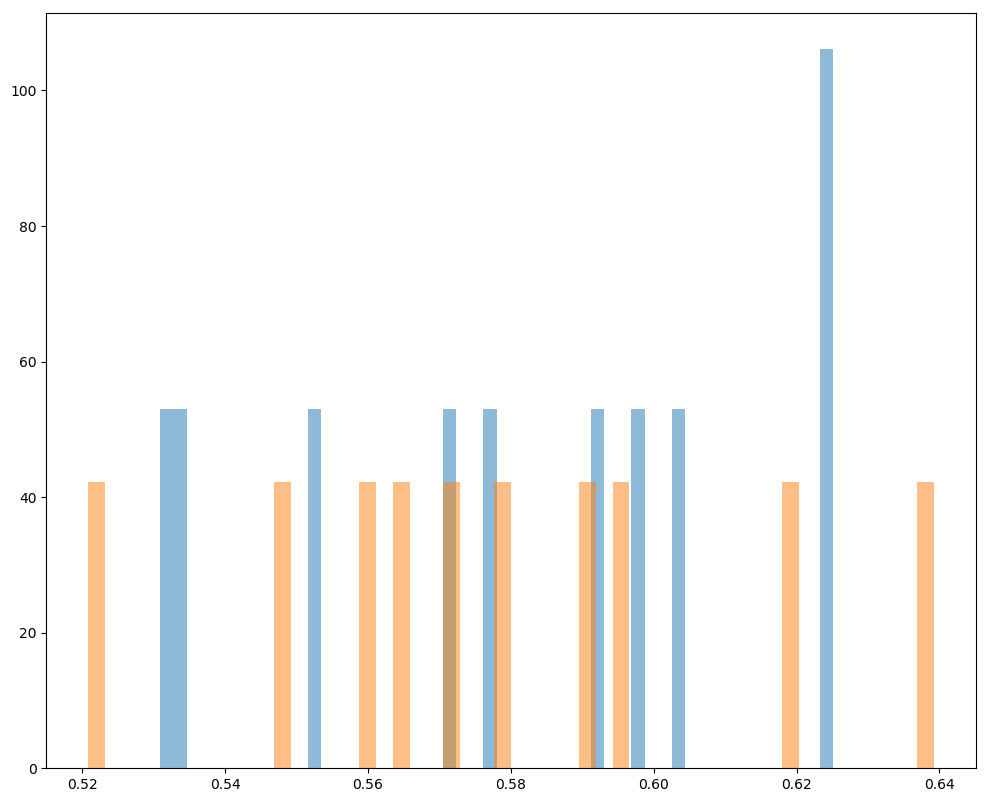

train singular values distribution


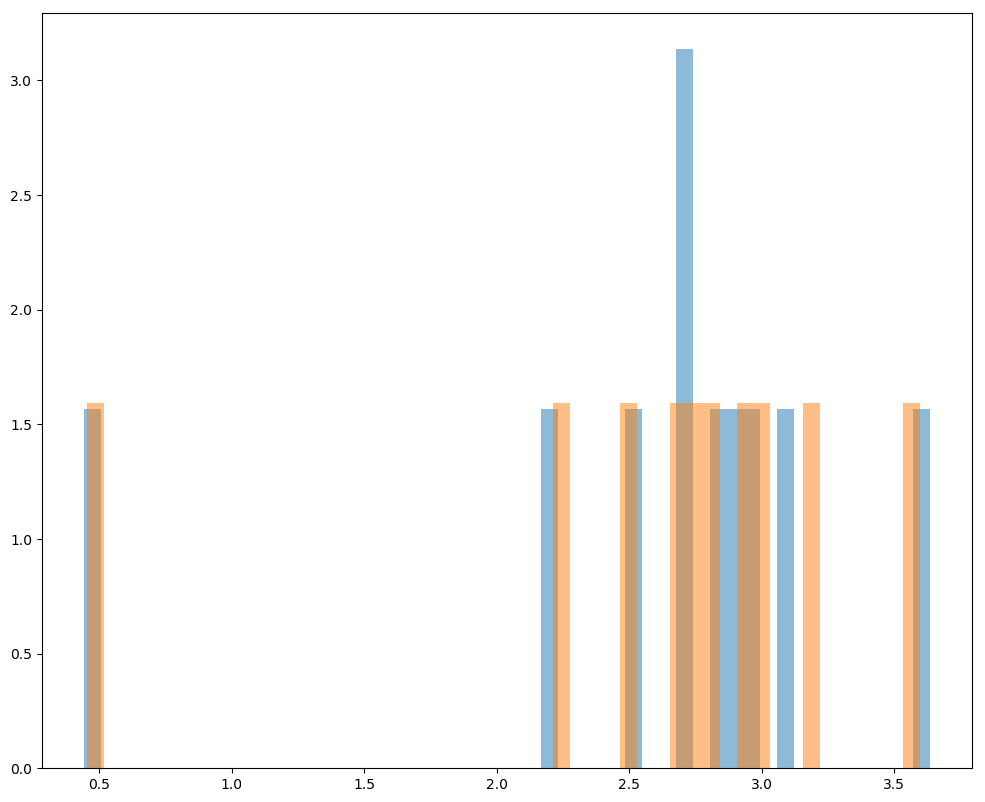

train and initial singular values distribution


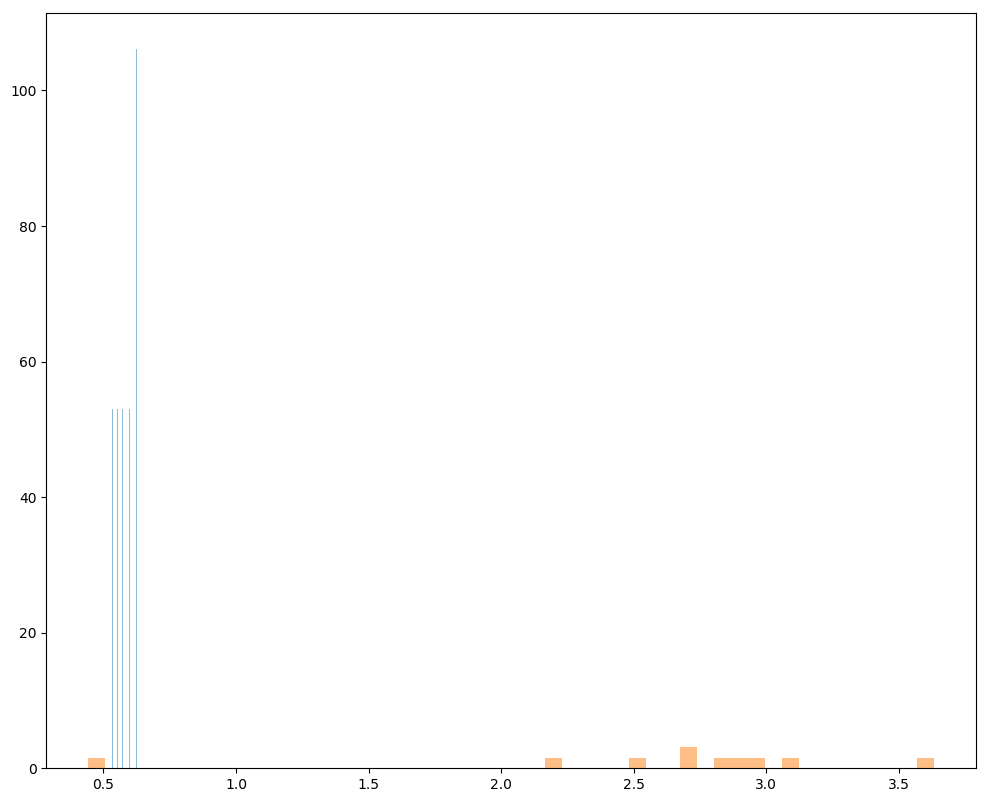

In [63]:
for i in range(2, 12, 2):
    print('index = ', i, list(model1.parameters())[i].shape)
    print('='*20)
    print('='*20)
    look_at_models(model1, model2, model3, model4, architecture, i)